In [1]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from src.evaluate import evaluate_model, evaluate_model_with_errors, evaluate_multiclass_model
from scipy.stats import ttest_rel
from src.read_data import read_datasets
from src.rename import abbreviate_feature_sets

#directories for fold train-test data 
datasets = {
    'Unsmoothed': './data/derived/unsmoothed/',
    'B-spline': './data/derived/smoothed/bspline/',
    'P-spline': './data/derived/smoothed/pspline/'
}
#gene mapping
color_mapping = {
    'Genome': 'orange',
    'gag': 'purple',
    'pol': 'green',
    'gp120': 'blue',
    'gp41': 'brown',
    'None': 'gray',
    'All Ambiguities': 'red'
}

# FEATURE SETS (NO META)

In [4]:
# Feature set with smoothed features (excluding meta-features)
features_smoothed_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                                'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                                'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                                'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips',
                                'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips']

features_tanya = ['gag_lrtt', 'gp120_lrtt', 'pol_lrtt',
                  'gp41_tips', 'gag_tips', 'gp120_tips',
                  'gp41_maf12c',
                  'gag_maf3c', 'gp41_maf3c']

features_top10_corr_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                               'gag_lrtt', 'gag_maf3c',
                               'pol_lrtt',
                               'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'
                               'gp41_maf3c']

features_top10_corr_no_ambig = ['genome_lrtt','gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 
                                'genome_maf12c', 'gp120_maf12c', 
                                'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 'gp120_maf3c']

features_top10_fi_no_ambig = ["genome_lrtt", "genome_maf12c", 
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c"]

features_top11_fi_no_ambig = ["genome_lrtt", "genome_maf12c", "genome_maf3c",
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c"]

features_top12_fi_no_ambig = ["genome_lrtt", "genome_maf12c", "genome_maf3c", 
                             "gag_lrtt", "gag_maf3c", "gag_maf12c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c"]


In [5]:
base_features = [
    {'name': 'HIV-phyloTSI', 'features': features_tanya, 'Ambiguity_Features':'none', 'compatible_datasets':['P-spline']},
    {'name': 'RFECV', 'features': features_smoothed_no_meta, 'Ambiguity_Features':'none','compatible_datasets':['P-spline']},
    {'name': 'Top10 Correlated', 'features': features_top10_corr_no_ambig,'Ambiguity_Features':'none', 'compatible_datasets':['P-spline']},
    {'name': 'Top10 Important', 'features': features_top10_fi_no_ambig, 'Ambiguity_Features':'none', 'compatible_datasets':['P-spline']}, 
    {'name': 'Top11 Important', 'features': features_top11_fi_no_ambig, 'Ambiguity_Features':'none', 'compatible_datasets':['P-spline']},
    {'name': 'Top12 Important', 'features': features_top12_fi_no_ambig, 'Ambiguity_Features':'none', 'compatible_datasets':['P-spline']},
]

# IMPACT OF BSPLINE SMOOTHING

In [193]:
feature_sets = [
    # Unsmoothed and Smoothed Feature Set
    {'name': 'tanya', 'features': features_tanya, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']},
    {'name': 'common_features', 'features': features_smoothed_no_meta, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']},
    {'name': 'Top10_corr_no_meta', 'features': features_top10_corr_no_ambig, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']},
    {'name': 'Top10_fi_no_meta', 'features': features_top10_fi_no_ambig, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']}, 
    {'name': 'Top11_fi_no_meta', 'features': features_top11_fi_no_ambig, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']}, 
    {'name': 'Top12_fi_no_meta', 'features': features_top12_fi_no_ambig, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']}, 
]

all_results = pd.DataFrame()

for feature_set in feature_sets:
    for dataset_type, input_dir in datasets.items():
        #check if feature set is compatible with the dataset
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Construct feature set name based on dataset type
        feature_set_name = f"{feature_set['name']}_{dataset_type}"
        
        # Debugging statements
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type}")
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Dataset_Type'] = dataset_type  # Track dataset used
        all_results = pd.concat([all_results, metrics_df], ignore_index=True)

# Save all results
all_results.to_csv('all_performance_metrics.csv', index=False)
print("All performance metrics saved to 'all_performance_metrics.csv'")

Processing feature set: tanya with dataset: Unsmoothed
Fold 1: MSE = 0.19799113496592768, MAE = 0.3440680182007838, R² = 0.3022000872032906
Fold 2: MSE = 0.1734008120656695, MAE = 0.29573245832765216, R² = 0.3340617250034389
Fold 3: MSE = 0.252304171569113, MAE = 0.3865364099175814, R² = 0.43716433094386387
Fold 4: MSE = 0.23675768741080458, MAE = 0.3809192316848641, R² = 0.44595628657163644
Fold 5: MSE = 0.2797632628575773, MAE = 0.40787367122262574, R² = 0.39311950578961496

Overall Performance across all folds:
Overall MSE: 0.2263404818684328
Overall MAE: 0.3613038757173052
Overall R²: 0.5268153855632197
Processing feature set: tanya with dataset: B-spline
Fold 1: MSE = 0.18311225117767016, MAE = 0.33812817300543996, R² = 0.35463922197437603
Fold 2: MSE = 0.17692242405890574, MAE = 0.2924754228154322, R² = 0.32053712734991247
Fold 3: MSE = 0.23787116268840983, MAE = 0.3749658375197026, R² = 0.46936123105591177
Fold 4: MSE = 0.22117409593915593, MAE = 0.36788639478038004, R² = 0.4824

In [194]:
overall_df = all_results[all_results['Fold'] == 'Overall']

## PLOT

In [199]:
overall_df['Simplified_Feature_Set'] = overall_df['Feature_Set'].replace({
    'common_features_B-spline': 'RFECV',
    'common_features_P-spline': 'RFECV',
    'common_features_Unsmoothed': 'RFECV',
    'Top10_corr_no_meta_B-spline': 'Top10 Correlated',
    'Top10_corr_no_meta_P-spline': 'Top10 Correlated',
    'Top10_corr_no_meta_Unsmoothed': 'Top10 Correlated',
    'Top10_fi_no_meta_Unsmoothed': 'Top10 Important',
    'Top10_fi_no_meta_P-spline': 'Top10 Important',
    'Top10_fi_no_meta_B-spline': 'Top10 Important',
    'Top11_fi_no_meta_Unsmoothed': 'Top11 Important',
    'Top11_fi_no_meta_P-spline': 'Top11 Important',
    'Top11_fi_no_meta_B-spline': 'Top11 Important',
    'Top12_fi_no_meta_Unsmoothed': 'Top12 Important',
    'Top12_fi_no_meta_P-spline': 'Top12 Important',
    'Top12_fi_no_meta_B-spline': 'Top12 Important',
    'tanya_Unsmoothed': 'HIV-phyloTSI',
    'tanya_B-spline': 'HIV-phyloTSI',
    'tanya_P-spline': 'HIV-phyloTSI',
})

all_results['Simplified_Feature_Set'] = all_results['Feature_Set'].replace({
    'common_features_B-spline': 'RFECV',
    'common_features_P-spline': 'RFECV',
    'common_features_Unsmoothed': 'RFECV',
    'Top10_corr_no_meta_B-spline': 'Top10 Correlated',
    'Top10_corr_no_meta_P-spline': 'Top10 Correlated',
    'Top10_corr_no_meta_Unsmoothed': 'Top10 Correlated',
    'Top10_fi_no_meta_Unsmoothed': 'Top10 Important',
    'Top10_fi_no_meta_P-spline': 'Top10 Important',
    'Top10_fi_no_meta_B-spline': 'Top10 Important',
    'Top11_fi_no_meta_Unsmoothed': 'Top11 Important',
    'Top11_fi_no_meta_P-spline': 'Top11 Important',
    'Top11_fi_no_meta_B-spline': 'Top11 Important',
    'Top12_fi_no_meta_Unsmoothed': 'Top12 Important',
    'Top12_fi_no_meta_P-spline': 'Top12 Important',
    'Top12_fi_no_meta_B-spline': 'Top12 Important',
    'tanya_Unsmoothed': 'HIV-phyloTSI',
    'tanya_B-spline': 'HIV-phyloTSI',
    'tanya_P-spline': 'HIV-phyloTSI',
})

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_64334/4059666294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df['Simplified_Feature_Set'] = overall_df['Feature_Set'].replace({


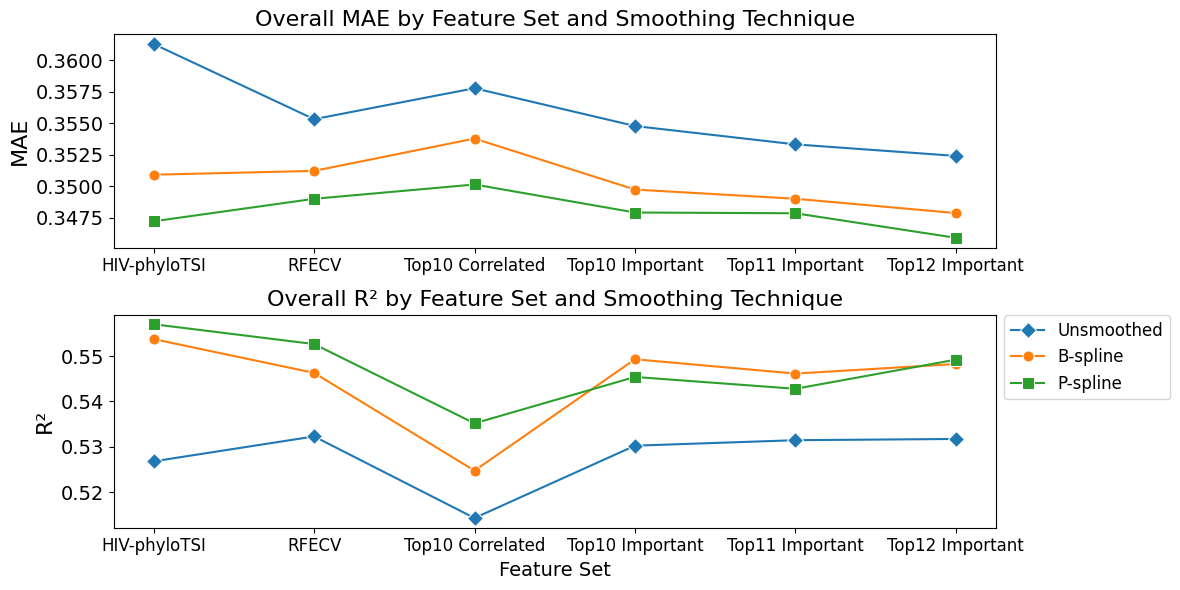

In [200]:
# Set up the plot
plt.figure(figsize=(14, 6))

markers = {'B-spline': 'o', 'P-spline': 's', 'Unsmoothed': 'D'}

# Plot MAE for 'Overall'
plt.subplot(2, 1, 1)
sns.lineplot(x='Simplified_Feature_Set', y='MAE', hue='Dataset_Type', style='Dataset_Type',
             markers=markers, dashes=False, data=overall_df, markersize = 8)
plt.title('Overall MAE by Feature Set and Smoothing Technique', fontsize = 16)
plt.xlabel('', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 12)
plt.ylabel('MAE', size = 16)
plt.legend([],[], frameon=False)
# Plot R² for 'Overall'
plt.subplot(2, 1, 2)
sns.lineplot(x='Simplified_Feature_Set', y='R²', hue='Dataset_Type', style='Dataset_Type',
             markers=markers, dashes=False, data=overall_df, markersize =8)
plt.title('Overall R² by Feature Set and Smoothing Technique', fontsize = 16)
plt.yticks(size = 14)
plt.xlabel('Feature Set', size = 14)
plt.xticks(size = 12)
plt.ylabel('R²', size = 16)
#move legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12) 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('./outputs/performance_comparisons/smoothing_comparison.pdf', bbox_inches='tight')
plt.show()

In [202]:
# Filter out the "Overall" rows
fold_level_data = all_results[all_results['Fold'] != 'Overall']

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_64334/3558705441.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(x='Simplified_Feature_Set', y='MAE', hue='Dataset_Type', data=fold_level_data,
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_64334/3558705441.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(x='Simplified_Feature_Set', y='R²', hue='Dataset_Type', data=fold_level_data,


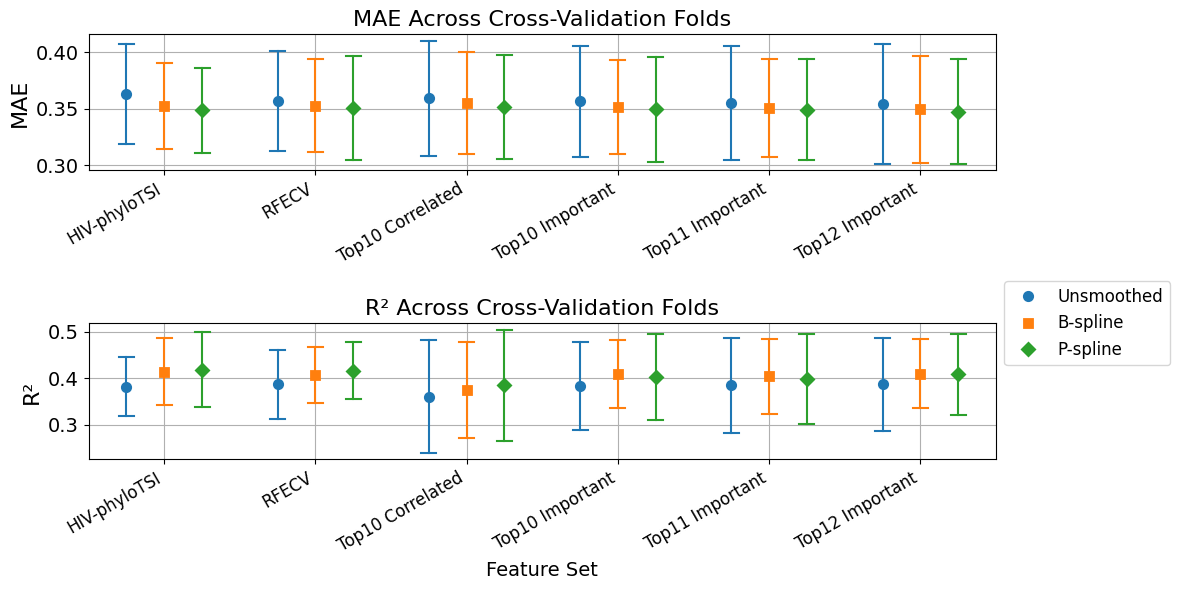

In [203]:
plt.figure(figsize=(14, 6))
custom_markers = ['o', 's', 'D']
# Plot MAE
plt.subplot(2, 1, 1)
sns.pointplot(x='Simplified_Feature_Set', y='MAE', hue='Dataset_Type', data=fold_level_data, 
              dodge=0.5, capsize=0.1, linestyle='none', errorbar='sd', errwidth=1.5, markers=custom_markers, markersize = 6)
plt.title('MAE Across Cross-Validation Folds', fontsize=16)
plt.xlabel('', size=14)
plt.yticks(size=14)
plt.xticks(size=12, rotation=30, ha='right') 
plt.ylabel('MAE', size=16)
plt.legend([], [], frameon=False)
plt.grid(True)

# Plot R²
plt.subplot(2, 1, 2)
sns.pointplot(x='Simplified_Feature_Set', y='R²', hue='Dataset_Type', data=fold_level_data, 
              dodge=0.5, capsize=0.1, linestyle='none', errorbar='sd', errwidth=1.5, markers=custom_markers, markersize = 6)
plt.title('R² Across Cross-Validation Folds', fontsize=16)
plt.yticks(size=14)
plt.xlabel('Feature Set', size=14)
plt.xticks(size=12, rotation=30, ha='right') 
plt.ylabel('R²', size=16)
plt.grid(True)

# Move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=12)

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('./outputs/performance_comparisons/smoothing_comparison_geom.pdf', bbox_inches='tight')
plt.show()

## Paired t-test

In [204]:
# Separate the data for unsmoothed, B-spline, and P-spline
unsmoothed_df = overall_df[overall_df['Dataset_Type'] == 'Unsmoothed']
bspline_df = overall_df[overall_df['Dataset_Type'] == 'B-spline']
pspline_df = overall_df[overall_df['Dataset_Type'] == 'P-spline']

# Paired t-test between unsmoothed and B-spline
t_stat_mae_bs, p_value_mae_bs = ttest_rel(unsmoothed_df['MAE'], bspline_df['MAE'])
t_stat_r2_bs, p_value_r2_bs = ttest_rel(unsmoothed_df['R²'], bspline_df['R²'])

# Paired t-test between unsmoothed and P-spline
t_stat_mae_ps, p_value_mae_ps = ttest_rel(unsmoothed_df['MAE'], pspline_df['MAE'])
t_stat_r2_ps, p_value_r2_ps = ttest_rel(unsmoothed_df['R²'], pspline_df['R²'])

# Display the results
print("Paired t-test for MAE (Unsmoothed vs B-spline): t-statistic = {}, p-value = {}".format(t_stat_mae_bs, p_value_mae_bs))
print("Paired t-test for R² (Unsmoothed vs B-spline): t-statistic = {}, p-value = {}".format(t_stat_r2_bs, p_value_r2_bs))

print("Paired t-test for MAE (Unsmoothed vs P-spline): t-statistic = {}, p-value = {}".format(t_stat_mae_ps, p_value_mae_ps))
print("Paired t-test for R² (Unsmoothed vs P-spline): t-statistic = {}, p-value = {}".format(t_stat_r2_ps, p_value_r2_ps))

Paired t-test for MAE (Unsmoothed vs B-spline): t-statistic = 5.357220646705303, p-value = 0.0030462141539194954
Paired t-test for R² (Unsmoothed vs B-spline): t-statistic = -7.324718244248065, p-value = 0.0007435473037190084
Paired t-test for MAE (Unsmoothed vs P-spline): t-statistic = 6.078357322645853, p-value = 0.0017418595872597301
Paired t-test for R² (Unsmoothed vs P-spline): t-statistic = -7.326427592107251, p-value = 0.0007427437980891565


# Impact of Meta Features 

In [6]:
global_meta_features = ['lrtt_coeff_1', 'lrtt_coeff_3', 'lrtt_coeff_11', 'lrtt_coeff_14', 'maf3c_coeff_1'] #complete list of meta features

all_results_meta = pd.DataFrame()

# Loop over each base feature set
for feature_set in base_features:
    for dataset_type, input_dir in datasets.items():
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Scenario 0: Base feature set without meta-features
        print(f"Processing base feature set: {feature_set['name']} with no meta features")
        feature_set_name = f"{feature_set['name']}_without_meta_features"
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Meta_Features'] = 'Without'  # Mark as without meta features
        metrics_df['Included_Meta_Features'] = 'None'
        all_results_meta = pd.concat([all_results_meta, metrics_df], ignore_index=True)

        for meta_feature in global_meta_features:
            current_features = feature_set['features'] + [meta_feature]
            feature_set_name = f"{feature_set['name']}_with_{meta_feature}"
            metrics_df = evaluate_model(input_dir, feature_set_name, current_features)
            metrics_df['Meta_Features'] = 'With'
            metrics_df['Included_Meta_Features'] = meta_feature 
            all_results_meta = pd.concat([all_results_meta, metrics_df], ignore_index=True)
        
        # Scenario 2: Base feature set with all meta-features combined
        current_features = feature_set['features'] + global_meta_features
        feature_set_name = f"{feature_set['name']}_with_all_meta_features"
        metrics_df = evaluate_model(input_dir, feature_set_name, current_features)
        metrics_df['Meta_Features'] = 'With'
        metrics_df['Included_Meta_Features'] = ', '.join(global_meta_features)  # Indicate all meta-features used
        all_results_meta = pd.concat([all_results_meta, metrics_df], ignore_index=True)
    

Processing base feature set: HIV-phyloTSI with no meta features
Fold 1: MSE = 0.19711507245372636, MAE = 0.34458712922538676, R² = 0.3052876817298018
Fold 2: MSE = 0.16494087165429286, MAE = 0.28536020030545883, R² = 0.36655175810658414
Fold 3: MSE = 0.22816446906045565, MAE = 0.3663913093586994, R² = 0.49101475096577174
Fold 4: MSE = 0.21886088440593968, MAE = 0.36511422687562883, R² = 0.48783712813479296
Fold 5: MSE = 0.2571363259115126, MAE = 0.38157983361216496, R² = 0.44220331520774303

Overall Performance across all folds:
Overall MSE: 0.21189743309265555
Overall MAE: 0.3472312346369954
Overall R²: 0.5570098448567649
Fold 1: MSE = 0.20473562122610198, MAE = 0.3468655258834798, R² = 0.27842982130215244
Fold 2: MSE = 0.15393876220742403, MAE = 0.27686910903037365, R² = 0.40880488079436283
Fold 3: MSE = 0.2309924966931708, MAE = 0.37652178532850844, R² = 0.4847060371031773
Fold 4: MSE = 0.19946108793542539, MAE = 0.3459594706110304, R² = 0.5332351694563763
Fold 5: MSE = 0.2360951191

In [7]:
fold_level_data_meta = all_results_meta[all_results_meta['Fold'] != 'Overall']
fold_level_data_meta['Included_Meta_Features'] = fold_level_data_meta['Included_Meta_Features'].fillna('None')
fold_level_data_meta['Included_Meta_Features'] = fold_level_data_meta['Included_Meta_Features'].astype('category')
fold_level_data_meta['Base_Feature_Set'] = fold_level_data_meta['Feature_Set'].str.extract(r'([^\_]+)')

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_3180/866225279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_level_data_meta['Included_Meta_Features'] = fold_level_data_meta['Included_Meta_Features'].fillna('None')
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_3180/866225279.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_level_data_meta['Included_Meta_Features'] = fold_level_data_meta['Included_Meta_Features'].astype('category')
/var/folders/rt/3hw_n0v124vg8h2q8k

In [10]:
fold_level_data_meta['Included_Meta_Features'] = fold_level_data_meta['Included_Meta_Features'].replace(
    'lrtt_coeff_1, lrtt_coeff_3, lrtt_coeff_11, lrtt_coeff_14, maf3c_coeff_1', 'All Coefficients')
included_meta_order = ['None','lrtt_coeff_1', 'lrtt_coeff_3', 'lrtt_coeff_11', 'lrtt_coeff_14', 'maf3c_coeff_1','All Coefficients']

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_3180/596435052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_level_data_meta['Included_Meta_Features'] = fold_level_data_meta['Included_Meta_Features'].replace(


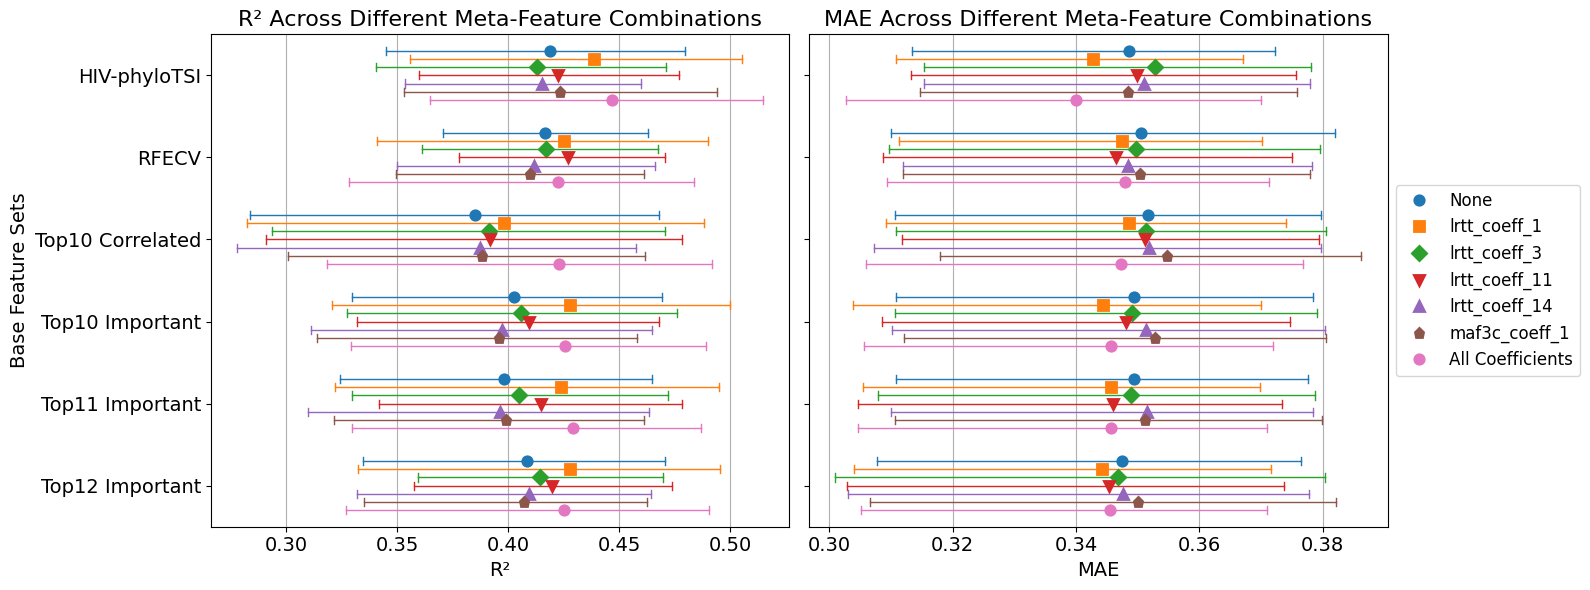

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
markers = ['o', 's', 'D', 'v', '^', 'p', 'o']
# R² plot
sns.pointplot(ax=axes[0], y='Base_Feature_Set', x='R²', data=fold_level_data_meta, hue='Included_Meta_Features', hue_order=included_meta_order,
              dodge=0.6, markers=markers, errorbar=('ci', 95), capsize=0.1, err_kws={'linewidth': 1}, linestyle='none')
axes[0].set_title('R² Across Different Meta-Feature Combinations', fontsize=16)
axes[0].set_ylabel('Base Feature Sets', fontsize=14)
axes[0].set_xlabel('R²', fontsize=14)
axes[0].grid(True, axis='x')
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].get_legend().remove()
# MAE plot
sns.pointplot(ax=axes[1], y='Base_Feature_Set', x='MAE', data=fold_level_data_meta, hue='Included_Meta_Features', hue_order=included_meta_order,
              dodge=0.6, markers=markers, errorbar=('ci', 95), capsize=0.1, err_kws={'linewidth': 1}, linestyle='none')
axes[1].set_title('MAE Across Different Meta-Feature Combinations', fontsize=16)
axes[1].set_ylabel('', fontsize=14)
axes[1].set_xlabel('MAE', fontsize=14)
axes[1].grid(True, axis='x')
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_yticklabels([])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.tight_layout()
plt.savefig('./outputs/performance_comparisons/spline_coefficient_comparison.pdf')
plt.show()

In [111]:
without_meta = fold_level_data_meta[fold_level_data_meta['Meta_Features'] == 'Without']['R²']

# Get the unique ambiguity feature groups, excluding none
meta_groups = fold_level_data_meta['Included_Meta_Features'].unique()
meta_groups = [group for group in meta_groups if group != 'None']
t_test_results = {}

# Loop through each ambiguity feature group and compare with 'None'
for group in meta_groups:
    with_meta = fold_level_data_meta[fold_level_data_meta['Included_Meta_Features'] == group]['R²']
    #paired t-test
    t_stat, p_value = ttest_rel(without_meta, with_meta)
    t_test_results[group] = {'t-statistic': t_stat, 'p-value': p_value}

t_test_results_df = pd.DataFrame(t_test_results).T
t_test_results_df

,t-statistic,p-value
lrtt_coeff_1,-2.911633,0.006847
lrtt_coeff_3,-1.230607,0.228358
lrtt_coeff_11,-4.713619,0.000056
lrtt_coeff_14,0.527628,0.601771
maf3c_coeff_1,0.248613,0.805412
All Coefficients,-2.899154,0.007061


In [119]:
t_test_results = {}

for group in meta_groups:
    with_meta = fold_level_data_meta[fold_level_data_meta['Included_Meta_Features'] == group]['R²']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(without_meta, with_meta)
    t_test_results[group] = {'t-statistic': t_stat, 'p-value': p_value}

t_test_results_df = pd.DataFrame(t_test_results).T
print(t_test_results_df)

                  t-statistic   p-value
lrtt_coeff_1        -2.911633  0.006847
lrtt_coeff_3        -1.230607  0.228358
lrtt_coeff_11       -4.713619  0.000056
lrtt_coeff_14        0.527628  0.601771
maf3c_coeff_1        0.248613  0.805412
All Coefficients    -2.899154  0.007061


In [35]:
without_meta = fold_level_data_meta[fold_level_data_meta['Meta_Features'] == 'Without']['MAE']

# Get the unique ambiguity feature groups (excluding 'None')
meta_groups = fold_level_data_meta['Included_Meta_Features'].unique()
meta_groups = [group for group in meta_groups if group != 'None']

# Dictionary to store t-statistic and p-value for each comparison
t_test_results = {}

# Loop through each ambiguity feature group and compare with 'None'
for group in meta_groups:
    with_meta = fold_level_data_meta[fold_level_data_meta['Included_Meta_Features'] == group]['MAE']
    # Perform paired t-test
    t_stat, p_value = ttest_rel(without_meta, with_meta)
    
    # Store the results
    t_test_results[group] = {'t-statistic': t_stat, 'p-value': p_value}

# Convert results to DataFrame for easier viewing
t_test_results_df = pd.DataFrame(t_test_results).T
t_test_results_df

,t-statistic,p-value
lrtt_coeff_1,2.273517,0.030580
lrtt_coeff_3,-0.398617,0.693095
lrtt_coeff_11,2.375458,0.024354
lrtt_coeff_14,-0.775800,0.444148
maf3c_coeff_1,-0.930665,0.359710
All Coefficients,1.704146,0.099048


# Impact of Ambiguities

## A- Most Correlated Ambiguity

In [68]:
f1_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                        'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                        'gp41_maf12c', 'gp41_maf3c',
                        'lrtt_coeff_1'] #meta features
f1_with_ambig = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                        'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                        'gp41_maf12c', 'gp41_maf3c',
                        'lrtt_coeff_1'] #meta features

f2_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                         'gp41_maf12c', 'gp41_maf3c',
                         'lrtt_coeff_1', 'lrtt_coeff_3'] #meta features
f2_with_ambig = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                         'gp41_maf12c', 'gp41_maf3c',
                         'lrtt_coeff_1', 'lrtt_coeff_3'] #meta features

f5_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt', 
                         'gp120_lrtt', 'gp120_maf12c', 
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3'] #meta features
f5_with_ambig = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_ambig',
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3']

f7_with_ambig = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt',
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_ambig',
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3']
f7_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt',
                         'gp120_lrtt', 'gp120_maf12c', 
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3', 'gp120_maf3c'] #meta features

top10_fi_with_meta = ['genome_lrtt',
                     'gag_lrtt', 'gag_maf3c',
                     'pol_maf3c', 
                     'gp120_lrtt', 'gp120_maf3c',
                     'lrtt_coeff_1',
                     'maf12c_coeff_4',
                     'maf3c_coeff_0', 'maf3c_coeff_2']
top10_fi_with_ambig = ["genome_lrtt", "genome_maf12c", 
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c", 'gp120_ambig']

top11_fi_with_meta = ['genome_lrtt',
                     'gag_lrtt', 'gag_maf3c',
                     'pol_maf3c', 
                     'gp120_lrtt', 'gp120_maf3c',
                     'lrtt_coeff_1',
                     'maf3c_coeff_0', 'maf3c_coeff_2']
top11_fi_with_ambig = ["genome_lrtt", "genome_maf12c", "genome_maf3c",
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c", "gp120_ambig"]

In [99]:
feature_sets_ambig = [
    # Smoothed Feature Sets with meta data (B-spline and P-spline)
    {'name': 'Set 1', 'Ambiguity_Features':'gp120_ambig', 'features': f1_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Set 1', 'Ambiguity_Features':'none', 'features': f1_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 2', 'Ambiguity_Features':'gp120_ambig', 'features': f2_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Set 2','Ambiguity_Features':'none', 'features': f2_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 5', 'Ambiguity_Features':'gp120_ambig', 'features': f5_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Set 5', 'Ambiguity_Features':'none', 'features': f5_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 7', 'Ambiguity_Features':'gp120_ambig', 'features': f7_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Set 7', 'Ambiguity_Features':'none', 'features': f7_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top10 Important', 'Ambiguity_Features':'gp120_ambig', 'features': top10_fi_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Top10 Important', 'Ambiguity_Features':'none', 'features': top10_fi_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top11 Important', 'Ambiguity_Features':'gp120_ambig', 'features': top11_fi_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Top11 Important', 'Ambiguity_Features':'none', 'features': top11_fi_with_meta, 'compatible_datasets':['P-spline']},
]

In [100]:
all_results_ambig = pd.DataFrame()

for feature_set in feature_sets_ambig:
    for dataset_type, input_dir in datasets.items():
        # Check if the feature set is compatible with the dataset
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Construct feature set name based on dataset type
        feature_set_name = f"{feature_set['name']}"
        
        # Debugging print statements
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type}")
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Ambiguity_Features'] = feature_set['Ambiguity_Features']
        
        # Store results
        all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)

# Save all results to a single CSV file
all_results_ambig.to_csv('performance_metrics_ambiguity_features.csv', index=False)
print("All performance metrics saved to 'performance_metrics_ambiguity_features.csv'")

Processing feature set: Set 1 with dataset: P-spline
Fold 1: MSE = 0.19347974329890924, MAE = 0.34381469797319325, R² = 0.31810003500842343
Fold 2: MSE = 0.15029259132392253, MAE = 0.2696539314046008, R² = 0.4228078414470622
Fold 3: MSE = 0.22769914303133332, MAE = 0.36880820461605085, R² = 0.4920527920148019
Fold 4: MSE = 0.23049913254675766, MAE = 0.37614235851807726, R² = 0.46060211714842836
Fold 5: MSE = 0.2284252731921082, MAE = 0.356681982618016, R² = 0.5044851805451618

Overall Performance across all folds:
Overall MSE: 0.20479177093708756
Overall MAE: 0.3416528258830866
Overall R²: 0.5718648543523923
Processing feature set: Set 1 with dataset: P-spline
Fold 1: MSE = 0.20884141172799028, MAE = 0.35712247294876787, R² = 0.26395937415474724
Fold 2: MSE = 0.15622756224573356, MAE = 0.27576122910307854, R² = 0.40001484382067976
Fold 3: MSE = 0.22629385081921224, MAE = 0.3669015225496169, R² = 0.4951876929461243
Fold 4: MSE = 0.22867626765969992, MAE = 0.37331528473521547, R² = 0.464

In [101]:
overall_ambig = all_results_ambig[all_results_ambig['Fold'] == 'Overall']

### plot

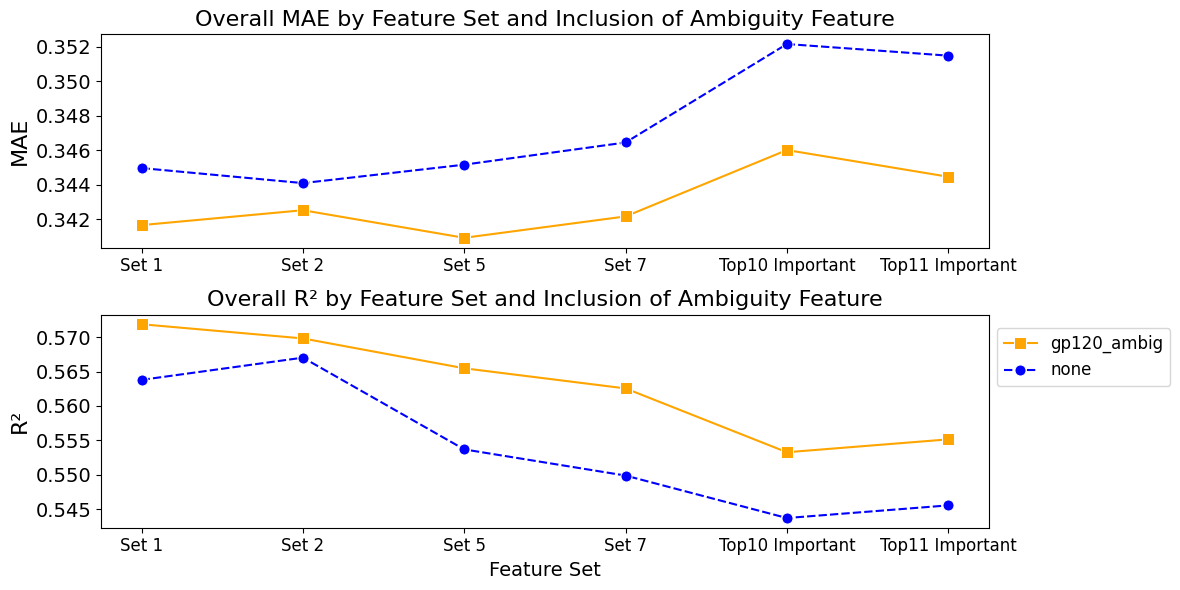

In [102]:
plt.figure(figsize=(14, 6))

markers = {'none': 'o', 'gp120_ambig': 's'}

# Plot MAE for 'Overall'
plt.subplot(2, 1, 1)
sns.lineplot(x='Feature_Set', y='MAE', 
             hue='Ambiguity_Features', 
             palette=['orange', 'blue'],
             style='Ambiguity_Features',
             markers=markers, markersize = 8, 
             data=overall_ambig)
plt.title('Overall MAE by Feature Set and Inclusion of Ambiguity Feature', fontsize = 16)
plt.xlabel('', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 12)
plt.ylabel('MAE', size = 16)
plt.legend([],[], frameon=False)
# Plot R² for 'Overall'
plt.subplot(2, 1, 2)
sns.lineplot(x='Feature_Set', y='R²', 
             hue='Ambiguity_Features', 
             palette=['orange', 'blue'],
             style='Ambiguity_Features',
             markers=markers,
            dashes=True, data=overall_ambig, markersize =8)
plt.title('Overall R² by Feature Set and Inclusion of Ambiguity Feature', fontsize = 16)
plt.yticks(size = 14)
plt.xlabel('Feature Set', size = 14)
plt.xticks(size = 12)
plt.ylabel('R²', size = 16)
#move legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12) 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('./outputs/performance_comparisons/gp120_ambiguity_comparison.pdf', bbox_inches='tight')
plt.show()

### SIG TEST

In [103]:
t_test_results = []

# Metrics to compare
metrics = ['MAE', 'R²']

# Identify unique feature sets
feature_sets = overall_ambig['Feature_Set'].unique()

# Loop through each metric and perform the paired t-test
for metric in metrics:
    with_ambiguity = []
    without_ambiguity = []
    
    for feature_set in feature_sets:
        # Extract performance metrics for models without ambiguity features
        without_ambiguity_value = overall_ambig[(overall_ambig['Feature_Set'] == feature_set) &
                                                (overall_ambig['Ambiguity_Features'] == 'none')][metric].values
        # Extract performance metrics for models with ambiguity features
        with_ambiguity_value = overall_ambig[(overall_ambig['Feature_Set'] == feature_set) &
                                             (overall_ambig['Ambiguity_Features'] == 'gp120_ambig')][metric].values
        
        # Ensure that both values are present
        if without_ambiguity_value.size > 0 and with_ambiguity_value.size > 0:
            without_ambiguity.append(without_ambiguity_value[0])
            with_ambiguity.append(with_ambiguity_value[0])

    # Perform paired t-test for the current metric
    t_statistic, p_value = ttest_rel(without_ambiguity, with_ambiguity)
    t_test_results.append((metric, t_statistic, p_value))

# Display results with Bonferroni correction
alpha_corrected = 0.05 / len(metrics)

for metric, t_stat, p_val in t_test_results:
    print(f"Paired t-test for {metric}: t-statistic = {t_stat}, p-value = {p_val}")
    if p_val < alpha_corrected:
        print(f"The result for {metric} is significant after Bonferroni correction (p < {alpha_corrected}).")
    else:
        print(f"The result for {metric} is not significant after Bonferroni correction (p >= {alpha_corrected}).")

Paired t-test for MAE: t-statistic = 5.543815152237016, p-value = 0.0026220681813092324
The result for MAE is significant after Bonferroni correction (p < 0.025).
Paired t-test for R²: t-statistic = -6.358178705464978, p-value = 0.001422055991497052
The result for R² is significant after Bonferroni correction (p < 0.025).


## B - Most Important Ambiguity

In [104]:
feature_sets_with_meta = {
    'f1_with_meta': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                     'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                     'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                     'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                     'gp41_maf12c', 'gp41_maf3c',
                     'lrtt_coeff_1'],
    'f2_with_meta': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                     'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                     'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                     'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                     'gp41_maf12c', 'gp41_maf3c',
                     'lrtt_coeff_1', 'lrtt_coeff_3'],
    'f5_with_meta': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                     'gag_lrtt', 'gag_maf3c', 
                     'pol_lrtt', 
                     'gp120_lrtt', 'gp120_maf12c', 
                     'gp41_maf3c', 
                     'lrtt_coeff_1', 'lrtt_coeff_3'],
    'f7_with_meta': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                     'gag_lrtt', 'gag_maf3c', 
                     'pol_lrtt',
                     'gp120_lrtt', 'gp120_maf12c', 
                     'gp41_maf3c', 
                     'lrtt_coeff_1', 'lrtt_coeff_3', 'gp120_maf3c'],
    'top10_fi_with_meta': ['genome_lrtt',
                           'gag_lrtt', 'gag_maf3c',
                           'pol_maf3c', 
                           'gp120_lrtt', 'gp120_maf3c',
                           'lrtt_coeff_1',
                           'maf12c_coeff_4',
                           'maf3c_coeff_0', 'maf3c_coeff_2'],
    'top11_fi_with_meta': ['genome_lrtt',
                           'gag_lrtt', 'gag_maf3c',
                           'pol_maf3c', 
                           'gp120_lrtt', 'gp120_maf3c',
                           'lrtt_coeff_1',
                           'maf3c_coeff_0', 'maf3c_coeff_2']
}

feature_sets_with_ambig = {}

# Loop through each feature set, add 'pol_ambig', and rename
for key, features in feature_sets_with_meta.items():
    # Create a copy of the feature set
    new_key = key.replace('_with_meta', '_with_ambig')
    new_features = features.copy()
    
    # Add 'pol_ambig' to the new feature set if not already present
    if 'pol_ambig' not in new_features:
        new_features.append('pol_ambig')
    
    # Store the new feature set in the new dictionary
    feature_sets_with_ambig[new_key] = new_features


In [109]:
feature_sets_ambig = []

# Loop through each feature set and create entries with and without 'pol_ambig'
for name, features in feature_sets_with_meta.items():
    # Create the feature set with ambiguity
    features_with_ambig = features.copy()
    if 'pol_ambig' not in features_with_ambig:
        features_with_ambig.append('pol_ambig')
    
    # Add the entries to the feature_sets_ambig list
    feature_sets_ambig.append({
        'name': name, 
        'Ambiguity_Features': 'pol_ambig', 
        'features': features_with_ambig, 
        'compatible_datasets': ['P-spline']
    })
    
    # Add the original feature set without ambiguity
    feature_sets_ambig.append({
        'name': name, 
        'Ambiguity_Features': 'none', 
        'features': features, 
        'compatible_datasets': ['P-spline']
    })

# Output the updated feature_sets_ambig list to verify
for entry in feature_sets_ambig:
    print(entry)

{'name': 'f1_with_meta', 'Ambiguity_Features': 'pol_ambig', 'features': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp41_maf12c', 'gp41_maf3c', 'lrtt_coeff_1', 'pol_ambig'], 'compatible_datasets': ['P-spline']}
{'name': 'f1_with_meta', 'Ambiguity_Features': 'none', 'features': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp41_maf12c', 'gp41_maf3c', 'lrtt_coeff_1'], 'compatible_datasets': ['P-spline']}
{'name': 'f2_with_meta', 'Ambiguity_Features': 'pol_ambig', 'features': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'gp120_lrtt', 'gp120_maf12c', 'gp120_ma

In [110]:
all_results_ambig = pd.DataFrame()

for feature_set in feature_sets_ambig:
    for dataset_type, input_dir in datasets.items():
        # Check if the feature set is compatible with the dataset
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Construct feature set name based on dataset type
        feature_set_name = f"{feature_set['name']}"
        
        # Debugging print statements
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type}")
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Ambiguity_Features'] = feature_set['Ambiguity_Features']
        
        # Store results
        all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)

# Save all results to a single CSV file
all_results_ambig.to_csv('performance_metrics_ambiguity_features.csv', index=False)
print("All performance metrics saved to 'performance_metrics_ambiguity_features.csv'")

Processing feature set: f1_with_meta with dataset: P-spline
Fold 1: MSE = 0.2076451383600234, MAE = 0.35572601935723275, R² = 0.2681755197513265
Fold 2: MSE = 0.15578756163597368, MAE = 0.2732894732155991, R² = 0.40170464702039
Fold 3: MSE = 0.22262674744149608, MAE = 0.3631015689848654, R² = 0.5033682020921236
Fold 4: MSE = 0.22327452492053096, MAE = 0.3681800560718569, R² = 0.4775086365568235
Fold 5: MSE = 0.22982836088131653, MAE = 0.35957839570916067, R² = 0.5014415123324389

Overall Performance across all folds:
Overall MSE: 0.20677437171565846
Overall MAE: 0.34278575095905206
Overall R²: 0.5677200536643057
Processing feature set: f1_with_meta with dataset: P-spline
Fold 1: MSE = 0.20884141172799028, MAE = 0.35712247294876787, R² = 0.26395937415474724
Fold 2: MSE = 0.15622756224573356, MAE = 0.27576122910307854, R² = 0.40001484382067976
Fold 3: MSE = 0.22629385081921224, MAE = 0.3669015225496169, R² = 0.4951876929461243
Fold 4: MSE = 0.22867626765969992, MAE = 0.37331528473521547,

In [112]:
overall_ambig = all_results_ambig[all_results_ambig['Fold'] == 'Overall']

### plot

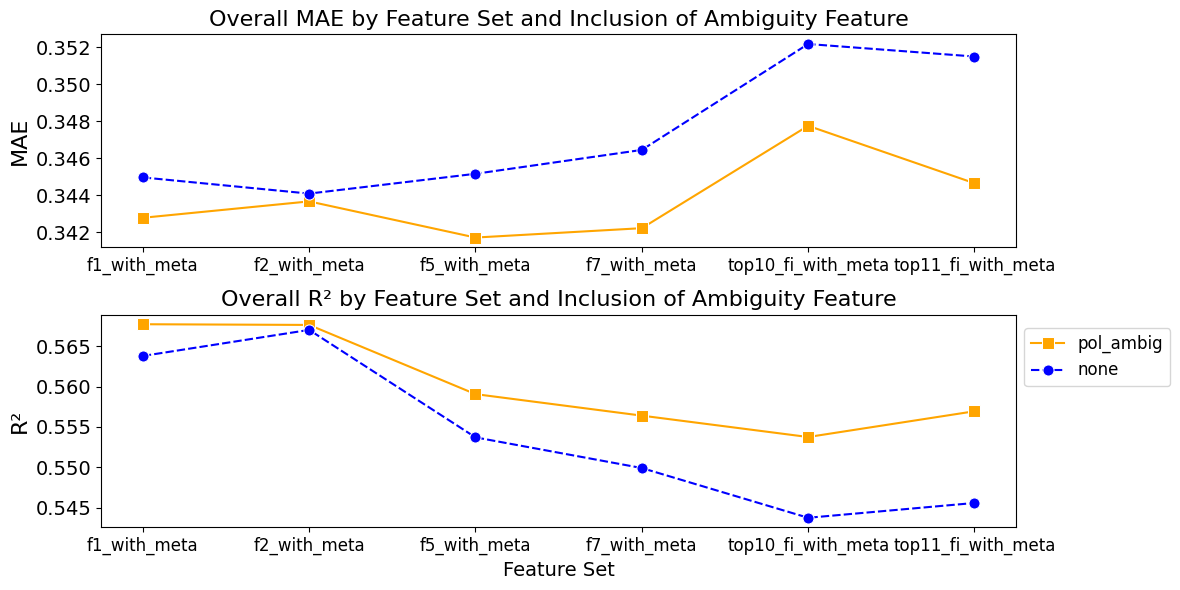

In [113]:
plt.figure(figsize=(14, 6))

markers = {'none': 'o', 'pol_ambig': 's'}

# Plot MAE for 'Overall'
plt.subplot(2, 1, 1)
sns.lineplot(x='Feature_Set', y='MAE', 
             hue='Ambiguity_Features', 
             palette=['orange', 'blue'],
             style='Ambiguity_Features',
             markers=markers, markersize = 8, 
             data=overall_ambig)
plt.title('Overall MAE by Feature Set and Inclusion of Ambiguity Feature', fontsize = 16)
plt.xlabel('', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 12)
plt.ylabel('MAE', size = 16)
plt.legend([],[], frameon=False)
# Plot R² for 'Overall'
plt.subplot(2, 1, 2)
sns.lineplot(x='Feature_Set', y='R²', 
             hue='Ambiguity_Features', 
             palette=['orange', 'blue'],
             style='Ambiguity_Features',
             markers=markers,
            dashes=True, data=overall_ambig, markersize =8)
plt.title('Overall R² by Feature Set and Inclusion of Ambiguity Feature', fontsize = 16)
plt.yticks(size = 14)
plt.xlabel('Feature Set', size = 14)
plt.xticks(size = 12)
plt.ylabel('R²', size = 16)
#move legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12) 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('./outputs/performance_comparisons/pol_ambiguity_comparison.pdf', bbox_inches='tight')
plt.show()

In [114]:
t_test_results = []

# Metrics to compare
metrics = ['MAE', 'R²']

# Identify unique feature sets
feature_sets = overall_ambig['Feature_Set'].unique()

# Loop through each metric and perform the paired t-test
for metric in metrics:
    with_ambiguity = []
    without_ambiguity = []
    
    for feature_set in feature_sets:
        # Extract performance metrics for models without ambiguity features
        without_ambiguity_value = overall_ambig[(overall_ambig['Feature_Set'] == feature_set) &
                                                (overall_ambig['Ambiguity_Features'] == 'none')][metric].values
        # Extract performance metrics for models with ambiguity features
        with_ambiguity_value = overall_ambig[(overall_ambig['Feature_Set'] == feature_set) &
                                             (overall_ambig['Ambiguity_Features'] == 'pol_ambig')][metric].values
        
        # Ensure that both values are present
        if without_ambiguity_value.size > 0 and with_ambiguity_value.size > 0:
            without_ambiguity.append(without_ambiguity_value[0])
            with_ambiguity.append(with_ambiguity_value[0])

    # Perform paired t-test for the current metric
    t_statistic, p_value = ttest_rel(without_ambiguity, with_ambiguity)
    t_test_results.append((metric, t_statistic, p_value))

# Display results with Bonferroni correction
alpha_corrected = 0.05 / len(metrics)

for metric, t_stat, p_val in t_test_results:
    print(f"Paired t-test for {metric}: t-statistic = {t_stat}, p-value = {p_val}")
    if p_val < alpha_corrected:
        print(f"The result for {metric} is significant after Bonferroni correction (p < {alpha_corrected}).")
    else:
        print(f"The result for {metric} is not significant after Bonferroni correction (p >= {alpha_corrected}).")

Paired t-test for MAE: t-statistic = 4.035215433630231, p-value = 0.00996970146093463
The result for MAE is significant after Bonferroni correction (p < 0.025).
Paired t-test for R²: t-statistic = -3.8980797288893636, p-value = 0.011431393980780852
The result for R² is significant after Bonferroni correction (p < 0.025).


## C - Comprehensive Ambiguity Impact

In [69]:
feature_sets_ambig = [
    # Smoothed Feature Sets with meta data (B-spline and P-spline)
    {'name': 'Set 1', 'Ambiguity_Features':'none', 'features': f1_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 2','Ambiguity_Features':'none', 'features': f2_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 5', 'Ambiguity_Features':'none', 'features': f5_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 7', 'Ambiguity_Features':'none', 'features': f7_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top10 Important', 'Ambiguity_Features':'none', 'features': top10_fi_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top11 Important', 'Ambiguity_Features':'none', 'features': top11_fi_with_meta, 'compatible_datasets':['P-spline']},
]

In [116]:
global_ambiguity_features = ['genome_ambig', 'gag_ambig', 'pol_ambig', 'gp120_ambig', 'gp41_ambig'] #complete list of ambiguity features

all_results_ambig = pd.DataFrame()

for feature_set in feature_sets_ambig:
    for dataset_type, input_dir in datasets.items():
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        # Scenario 0: Evaluate the base feature set without any ambiguity features
        print(f"Processing base feature set: {feature_set['name']} with dataset: {dataset_type} and no ambiguity features")
        # Evaluate the base feature set
        feature_set_name = f"{feature_set['name']}_without_ambiguity_features"
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Ambiguity_Features'] = 'Without'  # Mark as without ambiguity features

        # Store results for the base set
        all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)

        # Scenario 1: Evaluate with each individual ambiguity feature
        for ambiguity_feature in global_ambiguity_features:
            # Combine the original features with the individual ambiguity feature
            current_features = feature_set['features'] + [ambiguity_feature]
            
            # Debugging print statement
            print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type} and individual ambiguity feature: {ambiguity_feature}")
            
            # Construct feature set name based on dataset type and ambiguity feature
            feature_set_name = f"{feature_set['name']}_with_{ambiguity_feature}"
            
            # Evaluate model
            metrics_df = evaluate_model(input_dir, feature_set_name, current_features)
            metrics_df['Ambiguity_Features'] = ambiguity_feature  # Record the specific ambiguity feature
            
            # Store results
            all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)

        # Scenario 2: Evaluate with all ambiguity features combined
        current_features = feature_set['features'] + global_ambiguity_features
        
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type} and all ambiguity features combined")
        
        # Construct feature set name for all ambiguity features
        feature_set_name = f"{feature_set['name']}_with_all_ambiguity_features"
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, current_features)
        metrics_df['Ambiguity_Features'] = 'all' 
        
        # Store results
        all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)


Processing base feature set: Set 1 with dataset: P-spline and no ambiguity features
Fold 1: MSE = 0.20884141172799028, MAE = 0.35712247294876787, R² = 0.26395937415474724
Fold 2: MSE = 0.15622756224573356, MAE = 0.27576122910307854, R² = 0.40001484382067976
Fold 3: MSE = 0.22629385081921224, MAE = 0.3669015225496169, R² = 0.4951876929461243
Fold 4: MSE = 0.22867626765969992, MAE = 0.37331528473521547, R² = 0.46486785754380255
Fold 5: MSE = 0.2285903137837088, MAE = 0.3575505192393072, R² = 0.5041271638607256

Overall Performance across all folds:
Overall MSE: 0.2086535799201198
Overall MAE: 0.344962507102349
Overall R²: 0.5637914042139993
Processing feature set: Set 1 with dataset: P-spline and individual ambiguity feature: genome_ambig
Fold 1: MSE = 0.20614347643904424, MAE = 0.35316675647420964, R² = 0.27346797669738987
Fold 2: MSE = 0.15173077923850262, MAE = 0.26761191804799905, R² = 0.41728454332897924
Fold 3: MSE = 0.2330891205283858, MAE = 0.3755219492358311, R² = 0.480028925854

In [143]:
fold_level_data_ambig = all_results_ambig[all_results_ambig['Fold'] != 'Overall']
fold_level_data_ambig['Base_Feature_Set'] = fold_level_data_ambig['Feature_Set'].str.extract(r'([^\_]+)')

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_64334/3111622065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_level_data_ambig['Base_Feature_Set'] = fold_level_data_ambig['Feature_Set'].str.extract(r'([^\_]+)')


In [177]:
ambiguity_mapping = {
    'Without': 'None',
    'genome_ambig': 'Genome',
    'gag_ambig': 'gag',
    'pol_ambig': 'pol',
    'gp120_ambig': 'gp120',
    'gp41_ambig': 'gp41',
    'all': 'All Ambiguities'
}
fold_level_data_ambig['Ambiguity_Features'] = fold_level_data_ambig['Ambiguity_Features'].replace(ambiguity_mapping)


/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_64334/2863452033.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_level_data_ambig['Ambiguity_Features'] = fold_level_data_ambig['Ambiguity_Features'].replace(ambiguity_mapping)


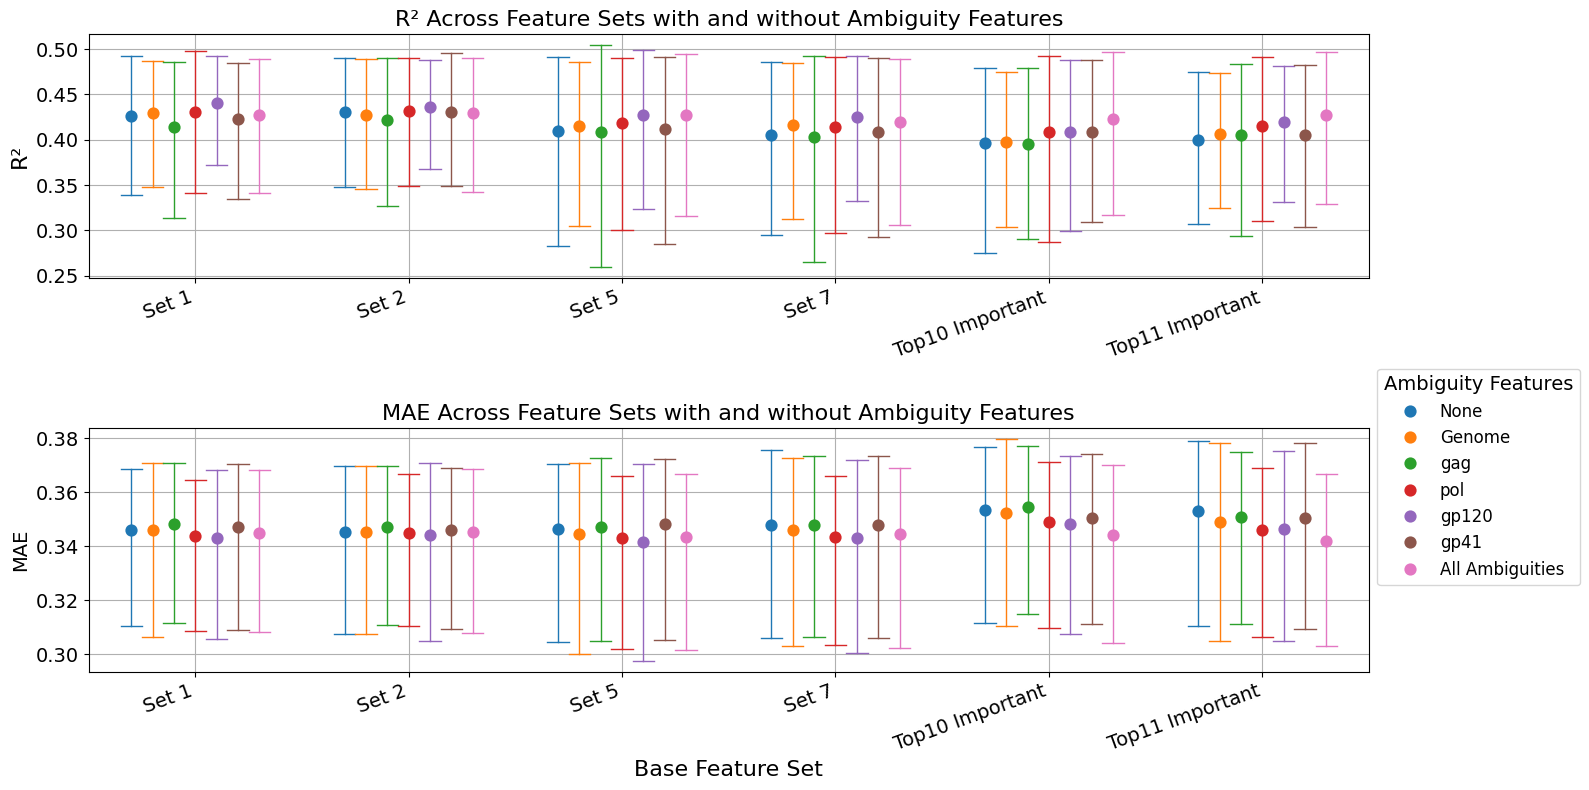

In [182]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
sns.pointplot(x='Base_Feature_Set', y='R²', hue='Ambiguity_Features', data=fold_level_data_ambig, 
              dodge=0.6, markers='o', linestyle ='none', capsize=0.1, err_kws={'linewidth': 1}, errorbar=('ci', 95))

# Add titles and labels
plt.title('R² Across Feature Sets with and without Ambiguity Features', fontsize=16)
plt.xlabel('')
plt.ylabel('R²', size = 16)
plt.xticks(rotation=20, ha='right', size = 14)
plt.yticks(size = 14)
plt.legend([], [], frameon=False)
plt.grid(True)

plt.subplot(2, 1, 2)
sns.pointplot(x='Base_Feature_Set', y='MAE', hue='Ambiguity_Features', data=fold_level_data_ambig, 
              dodge=0.6, markers='o', linestyle ='none', capsize=0.1, err_kws={'linewidth': 1}, errorbar=('ci', 95))

# Add titles and labels
plt.title('MAE Across Feature Sets with and without Ambiguity Features', fontsize=16)
plt.xlabel('Base Feature Set', size = 16)
plt.ylabel('MAE', size = 14)
plt.xticks(rotation=20, ha='right', size = 14)
plt.yticks(size = 14)
plt.grid(True)

# Move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12, title = "Ambiguity Features", title_fontsize='14')
plt.tight_layout()
plt.savefig('./outputs/performance_comparisons/ambiguity_comparison.pdf')
plt.show()

In [174]:
without_ambiguity = fold_level_data_ambig[fold_level_data_ambig['Ambiguity_Features'] == 'Without']['MAE']
with_all_ambiguity = fold_level_data_ambig[fold_level_data_ambig['Ambiguity_Features'] == 'all']['MAE']

# Perform paired t-test
t_stat, p_value = ttest_rel(without_ambiguity, with_all_ambiguity)
print(f'Paired t-test result: t-statistic = {t_stat}, p-value = {p_value}')

Paired t-test result: t-statistic = 3.8234107235953902, p-value = 0.0006447992070218561


# D - Comprehensive Ambiguity Impact - on Initial Feature Sets

In [235]:
global_ambiguity_features = ['genome_ambig', 'gag_ambig', 'pol_ambig', 'gp120_ambig', 'gp41_ambig'] #complete list of ambiguity features

all_results_ambig = pd.DataFrame()

for feature_set in feature_sets_ambig:
    for dataset_type, input_dir in datasets.items():
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        # Scenario 0: Evaluate the base feature set without any ambiguity features
        print(f"Processing base feature set: {feature_set['name']} with dataset: {dataset_type} and no ambiguity features")
        # Evaluate the base feature set
        feature_set_name = f"{feature_set['name']}_without_ambiguity_features"
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Ambiguity_Features'] = 'Without'  # Mark as without ambiguity features

        # Store results for the base set
        all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)

        # Scenario 1: Evaluate with each individual ambiguity feature
        for ambiguity_feature in global_ambiguity_features:
            # Combine the original features with the individual ambiguity feature
            current_features = feature_set['features'] + [ambiguity_feature]
            
            # Debugging print statement
            print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type} and individual ambiguity feature: {ambiguity_feature}")
            
            # Construct feature set name based on dataset type and ambiguity feature
            feature_set_name = f"{feature_set['name']}_with_{ambiguity_feature}"
            
            # Evaluate model
            metrics_df = evaluate_model(input_dir, feature_set_name, current_features)
            metrics_df['Ambiguity_Features'] = ambiguity_feature  # Record the specific ambiguity feature
            
            # Store results
            all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)

        # Scenario 2: Evaluate with all ambiguity features combined
        current_features = feature_set['features'] + global_ambiguity_features
        
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type} and all ambiguity features combined")
        
        # Construct feature set name for all ambiguity features
        feature_set_name = f"{feature_set['name']}_with_all_ambiguity_features"
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, current_features)
        metrics_df['Ambiguity_Features'] = 'all' 
        
        # Store results
        all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)


Processing base feature set: HIV-phyloTSI with dataset: P-spline and no ambiguity features
Fold 1: MSE = 0.19711507245372636, MAE = 0.34458712922538676, R² = 0.3052876817298018
Fold 2: MSE = 0.16494087165429286, MAE = 0.28536020030545883, R² = 0.36655175810658414
Fold 3: MSE = 0.22816446906045565, MAE = 0.3663913093586994, R² = 0.49101475096577174
Fold 4: MSE = 0.21886088440593968, MAE = 0.36511422687562883, R² = 0.48783712813479296
Fold 5: MSE = 0.2571363259115126, MAE = 0.38157983361216496, R² = 0.44220331520774303

Overall Performance across all folds:
Overall MSE: 0.21189743309265555
Overall MAE: 0.3472312346369954
Overall R²: 0.5570098448567649
Processing feature set: HIV-phyloTSI with dataset: P-spline and individual ambiguity feature: genome_ambig
Fold 1: MSE = 0.18723835169401984, MAE = 0.33467801670181463, R² = 0.3400971942164427
Fold 2: MSE = 0.152804813121741, MAE = 0.2704834031770339, R² = 0.4131597629258704
Fold 3: MSE = 0.2297812712790577, MAE = 0.3713552048393242, R² = 0

In [236]:
fold_level_data_ambig = all_results_ambig[all_results_ambig['Fold'] != 'Overall']
fold_level_data_ambig['Base_Feature_Set'] = fold_level_data_ambig['Feature_Set'].str.extract(r'([^\_]+)')

ambiguity_mapping = {
    'Without': 'None',
    'genome_ambig': 'Genome',
    'gag_ambig': 'gag',
    'pol_ambig': 'pol',
    'gp120_ambig': 'gp120',
    'gp41_ambig': 'gp41',
    'all': 'All Ambiguities'
}
fold_level_data_ambig['Ambiguity_Features'] = fold_level_data_ambig['Ambiguity_Features'].replace(ambiguity_mapping)

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_64334/1823577860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_level_data_ambig['Base_Feature_Set'] = fold_level_data_ambig['Feature_Set'].str.extract(r'([^\_]+)')
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_64334/1823577860.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_level_data_ambig['Ambiguity_Features'] = fold_level_data_ambig['Ambiguity_Features'].replace(ambiguity_mapping)


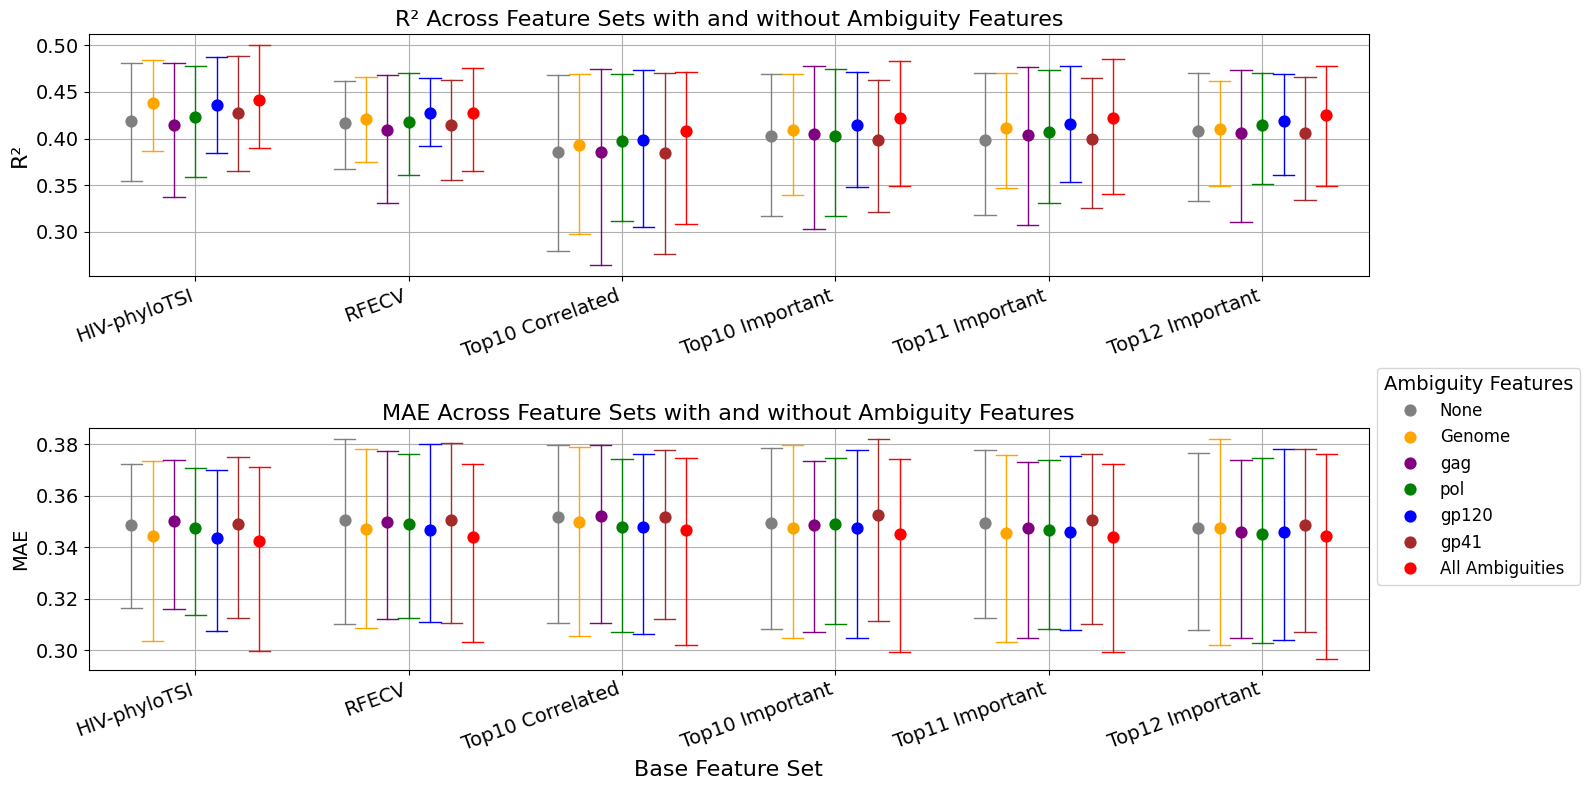

In [237]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
sns.pointplot(x='Base_Feature_Set', y='R²', hue='Ambiguity_Features', data=fold_level_data_ambig, palette=color_mapping,
              dodge=0.6, markers='o', linestyle ='none', capsize=0.1, err_kws={'linewidth': 1}, errorbar=('ci', 95))

plt.title('R² Across Feature Sets with and without Ambiguity Features', fontsize=16)
plt.xlabel('')
plt.ylabel('R²', size = 16)
plt.xticks(rotation=20, ha='right', size = 14)
plt.yticks(size = 14)
plt.legend([], [], frameon=False)
plt.grid(True)

plt.subplot(2, 1, 2)
sns.pointplot(x='Base_Feature_Set', y='MAE', hue='Ambiguity_Features', data=fold_level_data_ambig,  palette=color_mapping,
              dodge=0.6, markers='o', linestyle ='none', capsize=0.1, err_kws={'linewidth': 1}, errorbar=('ci', 95))

plt.title('MAE Across Feature Sets with and without Ambiguity Features', fontsize=16)
plt.xlabel('Base Feature Set', size = 16)
plt.ylabel('MAE', size = 14)
plt.xticks(rotation=20, ha='right', size = 14)
plt.yticks(size = 14)
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12, title = "Ambiguity Features", title_fontsize='14')
plt.tight_layout()
plt.savefig('./outputs/performance_comparisons/ambiguity_comparison.pdf')
plt.show()

### t-tests

In [242]:
ithout_ambiguity = fold_level_data_ambig[fold_level_data_ambig['Ambiguity_Features'] == 'None']['R²']

# Get the unique ambiguity feature groups (excluding 'None')
ambiguity_groups = fold_level_data_ambig['Ambiguity_Features'].unique()
ambiguity_groups = [group for group in ambiguity_groups if group != 'None']

# Dictionary to store t-statistic and p-value for each comparison
t_test_results = {}

# Loop through each ambiguity feature group and compare with 'None'
for group in ambiguity_groups:
    with_ambiguity = fold_level_data_ambig[fold_level_data_ambig['Ambiguity_Features'] == group]['R²']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(without_ambiguity, with_ambiguity)
    
    # Store the results
    t_test_results[group] = {'t-statistic': t_stat, 'p-value': p_value}

# Convert results to DataFrame for easier viewing
t_test_results_df = pd.DataFrame(t_test_results).T
t_test_results_df

,t-statistic,p-value
Genome,-5.124678,0.000018
gag,-3.251125,0.002911
pol,-4.408652,0.000131
gp120,-5.876154,0.000002
gp41,-3.997978,0.000402
All Ambiguities,-5.211323,0.000014


In [241]:
ithout_ambiguity = fold_level_data_ambig[fold_level_data_ambig['Ambiguity_Features'] == 'None']['MAE']

# Get the unique ambiguity feature groups (excluding 'None')
ambiguity_groups = fold_level_data_ambig['Ambiguity_Features'].unique()
ambiguity_groups = [group for group in ambiguity_groups if group != 'None']

# Dictionary to store t-statistic and p-value for each comparison
t_test_results = {}

# Loop through each ambiguity feature group and compare with 'None'
for group in ambiguity_groups:
    with_ambiguity = fold_level_data_ambig[fold_level_data_ambig['Ambiguity_Features'] == group]['MAE']
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(without_ambiguity, with_ambiguity)
    
    # Store the results
    t_test_results[group] = {'t-statistic': t_stat, 'p-value': p_value}

# Convert results to DataFrame for easier viewing
t_test_results_df = pd.DataFrame(t_test_results).T
t_test_results_df

,t-statistic,p-value
Genome,2.612029,0.014109
gag,0.506278,0.616489
pol,2.994282,0.005578
gp120,5.429503,0.000008
gp41,-1.620761,0.115893
All Ambiguities,4.057055,0.000343


# FEATURE SET COMPARISON

In [220]:
feature_sets = {
    #BEST WITH POL AMBIGUITY
    'f1_with_pol': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                    'gp41_maf12c', 'gp41_maf3c', 'lrtt_coeff_1'],
    
    'f2_with_pol': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                    'gp41_maf12c', 'gp41_maf3c', 'lrtt_coeff_1', 'lrtt_coeff_3'],
    #BEST WITH GP120 AMBIGUITY
    'f1_with_gp120': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                      'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                      'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips',
                      'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                      'gp41_maf12c', 'gp41_maf3c', 'lrtt_coeff_1'],

    'f2_with_gp120': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                      'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                      'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                      'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                      'gp41_maf12c', 'gp41_maf3c', 'lrtt_coeff_1', 'lrtt_coeff_3'],
    #FEATURE IMPORTANCE
    'top_10_fi': [
        "genome_lrtt", "gag_lrtt", "lrtt_coeff_1", 
        "gag_maf3c", "lrtt_coeff_14", "gp120_lrtt", 
        "maf3c_coeff_1", "maf3c_coeff_0", "lrtt_coeff_13", "lrtt_coeff_2"
    ],

    'top_11_fi': [
        "genome_lrtt", "gag_lrtt", "lrtt_coeff_1", 
        "gag_maf3c", "lrtt_coeff_14", "gp120_lrtt", 
        "maf3c_coeff_1", "maf3c_coeff_0", "lrtt_coeff_13", 
        "lrtt_coeff_2", "lrtt_coeff_5"
    ],

    'top_12_fi': [
        "genome_lrtt", "gag_lrtt", "lrtt_coeff_1", 
        "gag_maf3c", "lrtt_coeff_14", "gp120_lrtt", 
        "maf3c_coeff_1", "maf3c_coeff_0", "lrtt_coeff_13", 
        "lrtt_coeff_2", "lrtt_coeff_5", "pol_ambig"
    ],
    'top_13_fi': [
        "genome_lrtt", "gag_lrtt", "lrtt_coeff_1", 
        "gag_maf3c", "lrtt_coeff_14", "gp120_lrtt", 
        "maf3c_coeff_1", "maf3c_coeff_0", "lrtt_coeff_13", 
        "lrtt_coeff_2", "lrtt_coeff_5", "pol_ambig", "lrtt_coeff_0"
    ],
    'top_14_fi': [
        "genome_lrtt", "gag_lrtt", "lrtt_coeff_1", 
        "gag_maf3c", "lrtt_coeff_14", "gp120_lrtt", 
        "maf3c_coeff_1", "maf3c_coeff_0", "lrtt_coeff_13", 
        "lrtt_coeff_2", "lrtt_coeff_5", "pol_ambig", "lrtt_coeff_0", "pol_maf3c"
    ],
}

In [148]:
input_dir = './data/derived/smoothed/pspline/'

In [149]:
all_results = pd.DataFrame()

# Loop through each feature set and evaluate the model
for feature_set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {feature_set_name}")
    
    # Call the evaluate_model function
    metrics_df = evaluate_model(input_dir, feature_set_name, features)
    
    # Append the results to the master DataFrame
    all_results = pd.concat([all_results, metrics_df], ignore_index=True)

# Save all results to a CSV file
all_results.to_csv('performance_metrics_all_feature_sets.csv', index=False)
print("All performance metrics saved to 'performance_metrics_all_feature_sets.csv'")

# Optionally, display the results
print(all_results)

Evaluating feature set: f1_with_pol
Fold 1: MSE = 0.20962226612345988, MAE = 0.355675298844839, R² = 0.2612073310940346
Fold 2: MSE = 0.15511756848006408, MAE = 0.2727193538838421, R² = 0.4042777265878431
Fold 3: MSE = 0.22768533888678447, MAE = 0.36765454808620573, R² = 0.49208358605552105
Fold 4: MSE = 0.22224604511549523, MAE = 0.3668826227609778, R² = 0.4799154127700891
Fold 5: MSE = 0.23046921908347393, MAE = 0.36033237259702455, R² = 0.5000513214314912

Overall Performance across all folds:
Overall MSE: 0.20793556272994693
Overall MAE: 0.343417189110004
Overall R²: 0.5652924820790205
Evaluating feature set: f2_with_pol
Fold 1: MSE = 0.20388892269840989, MAE = 0.3533739759901499, R² = 0.28141392540807775
Fold 2: MSE = 0.15519074074299125, MAE = 0.27400598528658265, R² = 0.4039967116954051
Fold 3: MSE = 0.22492710961717763, MAE = 0.3640134342673716, R² = 0.4982365949681943
Fold 4: MSE = 0.2231828509591615, MAE = 0.37128987765121746, R² = 0.4777231655232841
Fold 5: MSE = 0.232605488

In [150]:
overall_df = all_results[all_results['Fold'] == 'Overall']

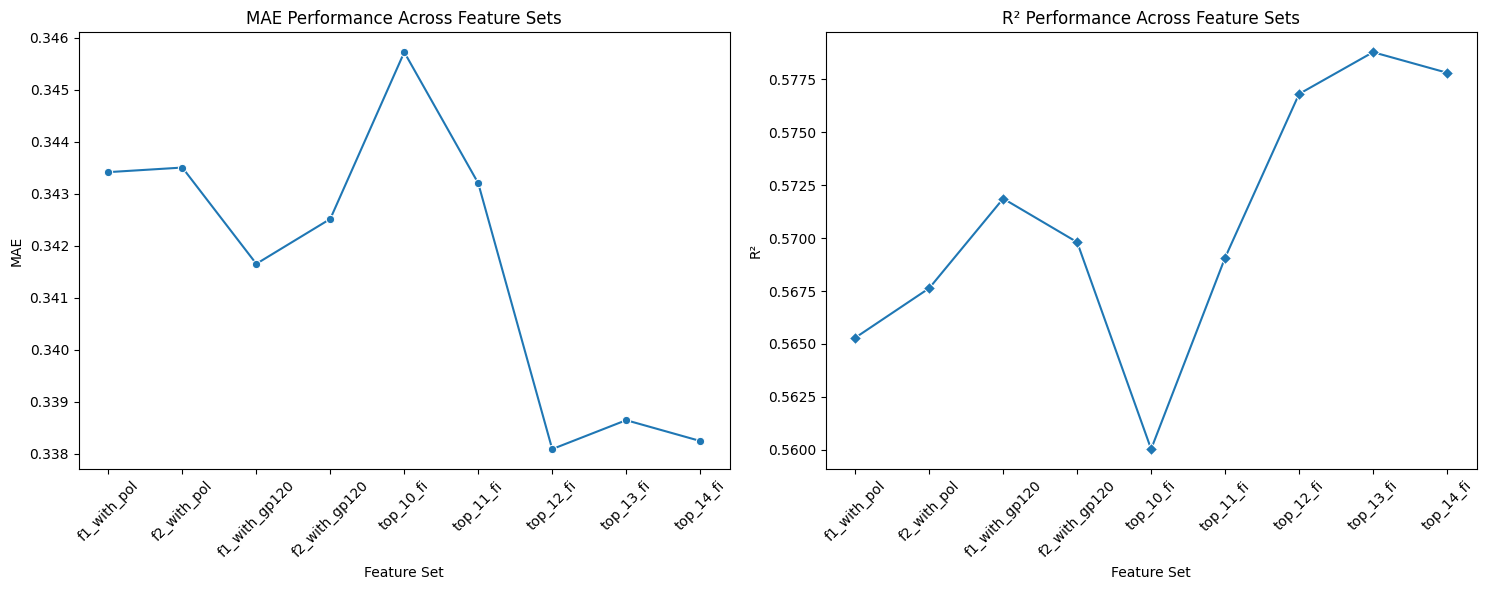

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(ax=axes[0], x='Feature_Set', y='MAE', data=overall_df, marker='o')
axes[0].set_title('MAE Performance Across Feature Sets')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(ax=axes[1], x='Feature_Set', y='R²', data=overall_df, marker='D')
axes[1].set_title('R² Performance Across Feature Sets')
axes[1].set_xlabel('Feature Set')
axes[1].set_ylabel('R²')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# FINAL FEATURE SET COMPARISON 

In [6]:
additional_features = ['genome_ambig', 'pol_ambig', 'gp120_ambig', 
                       'lrtt_coeff_1', 'lrtt_coeff_11']

feature_sets = {}
feature_sets['base'] = features_tanya
for feature in additional_features:
    feature_sets[f'base_plus_{feature}'] = features_tanya + [feature]

for i in range(1, len(additional_features) + 1):
    for combo in combinations(additional_features, i):
        combo_name = "_".join(combo)
        feature_sets[f'base_plus_{combo_name}'] = features_tanya + list(combo)

In [7]:
all_results = pd.DataFrame()
evaluation_results = {}

#pspline smoothing
input_dir = './data/derived/smoothed/pspline_10folds/'

for feature_set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {feature_set_name}")
    
    # Evaluate the model and get metrics and predictions
    metrics_df, all_y_true, all_y_pred, all_prediction_intervals = evaluate_model_with_errors(
        input_dir, feature_set_name, features, n_folds=10)
    
    # Append the fold-wise metrics to the final results DataFrame
    all_results = pd.concat([all_results, metrics_df], ignore_index=True)
    
    # Store the evaluation results for this feature set
    evaluation_results[feature_set_name] = {
        'metrics_df': metrics_df,
        'all_y_true': all_y_true,
        'all_y_pred': all_y_pred,
        'all_prediction_intervals': all_prediction_intervals
    }


Evaluating feature set: base
Fold 1: MSE = 0.18049409172427164, MAE = 0.3218218173257892, R² = 0.6145066790263602
Fold 2: MSE = 0.1145081461410507, MAE = 0.23237566834539228, R² = 0.6812497718690487
Fold 3: MSE = 0.26395768414966503, MAE = 0.4136479501276312, R² = 0.5623436254970154
Fold 4: MSE = 0.2323999337280133, MAE = 0.3476310432333417, R² = 0.6062260430303776
Fold 5: MSE = 0.2133556495696214, MAE = 0.31565163258079487, R² = 0.5839216611563295
Fold 6: MSE = 0.18790680144727745, MAE = 0.31993711524898555, R² = 0.5907346290387584
Fold 7: MSE = 0.17861793122008854, MAE = 0.30445401243701603, R² = 0.5930991885642342
Fold 8: MSE = 0.21573706938572762, MAE = 0.3655242869860531, R² = 0.6162161776484567
Fold 9: MSE = 0.17507726583453329, MAE = 0.31645959873328744, R² = 0.5701674545617592
Fold 10: MSE = 0.1469090352012975, MAE = 0.29235706298004743, R² = 0.5422729549798695
Evaluating feature set: base_plus_genome_ambig
Fold 1: MSE = 0.1694392204281665, MAE = 0.3106534218834494, R² = 0.6381

In [8]:
mean_r2 = all_results.groupby('Feature_Set')['R²'].mean().reset_index()
mean_r2_sorted = mean_r2.sort_values(by='R²', ascending=False)

In [9]:
def bootstrap_ci(data, num_bootstrap_samples=1000, confidence_level=0.95):
    bootstrap_results = []

    # Perform bootstrap sampling
    for _ in range(num_bootstrap_samples):
        # Resample with replacement from the data
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        
        # Calculate the statistic (e.g., mean R²)
        statistic = np.mean(bootstrap_sample)  # You could use other metrics here
        bootstrap_results.append(statistic)

    # Compute the confidence interval
    lower_bound = np.percentile(bootstrap_results, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_results, (1 + confidence_level) / 2 * 100)
    
    return lower_bound, upper_bound

bootstrap_results = []

for feature_set in mean_r2_sorted['Feature_Set']:
    r2_data = all_results[all_results['Feature_Set'] == feature_set]['R²']
    mae_data = all_results[all_results['Feature_Set'] == feature_set]['MAE']
    
    # Ensure data is valid before proceeding
    if r2_data.dropna().empty or mae_data.dropna().empty:
        lower_ci_r2, upper_ci_r2 = np.nan, np.nan
        lower_ci_mae, upper_ci_mae = np.nan, np.nan
    else:
        lower_ci_r2, upper_ci_r2 = bootstrap_ci(r2_data)
        lower_ci_mae, upper_ci_mae = bootstrap_ci(mae_data)
    
    mean_r2_value = r2_data.mean() if not r2_data.empty else np.nan
    mean_mae_value = mae_data.mean() if not mae_data.empty else np.nan

    bootstrap_results.append({
        'Feature_Set': feature_set,
        'Mean R²': mean_r2_value,
        'Lower CI R²': lower_ci_r2,
        'Upper CI R²': upper_ci_r2,
        'Mean MAE': mean_mae_value,
        'Lower CI MAE': lower_ci_mae,
        'Upper CI MAE': upper_ci_mae
    })
bootstrap_df = pd.DataFrame(bootstrap_results)

## plot

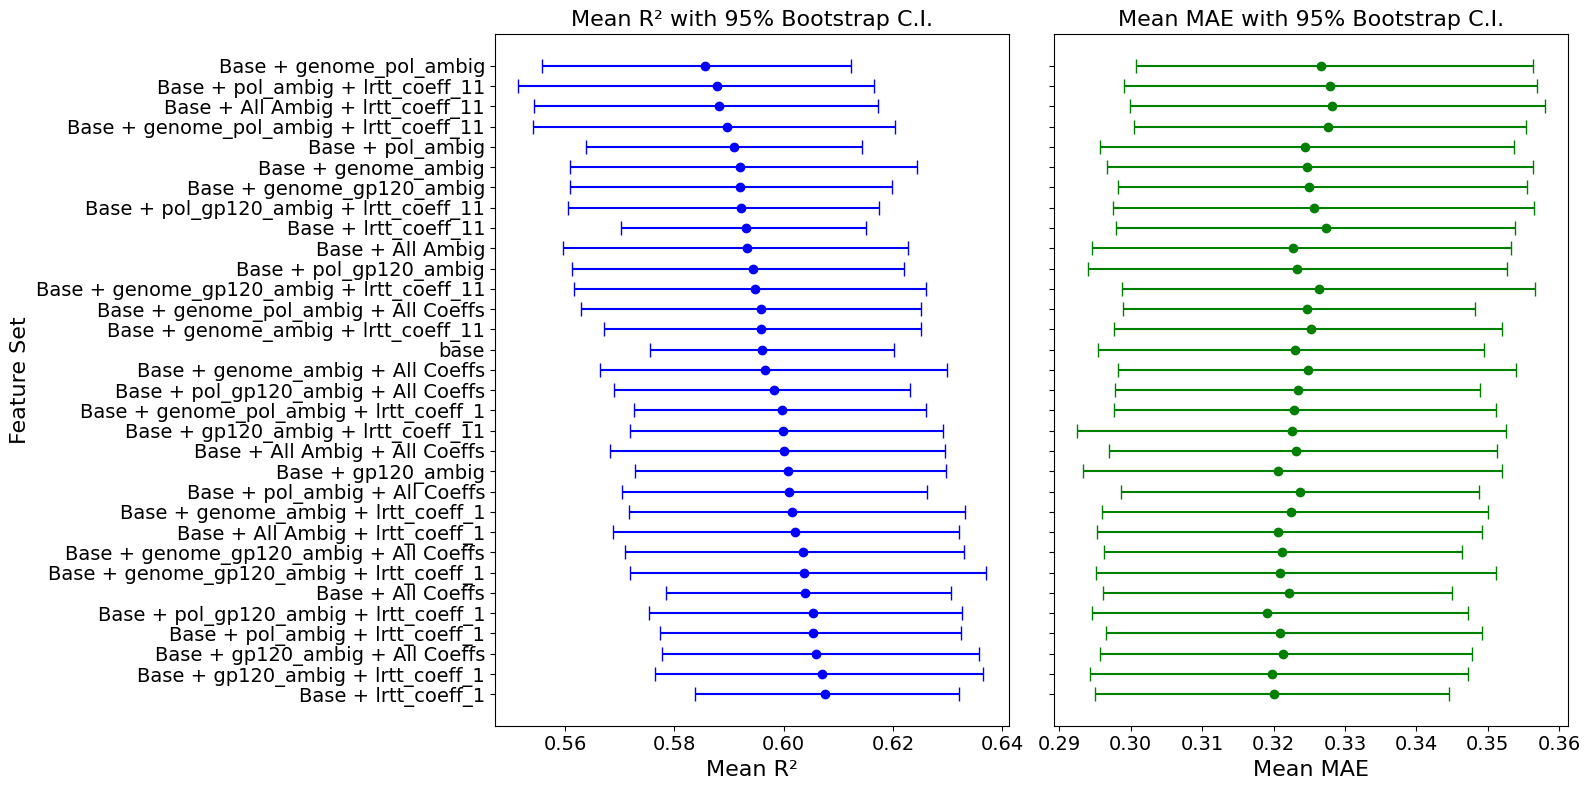

In [11]:
bootstrap_df_sorted = pd.merge(mean_r2_sorted, bootstrap_df, on='Feature_Set')
bootstrap_df_sorted = abbreviate_feature_sets(bootstrap_df_sorted) #change the feature set names 


fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the Mean R² with bootstrap confidence intervals
axes[0].errorbar(x=bootstrap_df_sorted['Mean R²'], 
                 y=bootstrap_df_sorted['Feature_Set'], 
                 xerr=[bootstrap_df_sorted['Mean R²'] - bootstrap_df_sorted['Lower CI R²'], 
                       bootstrap_df_sorted['Upper CI R²'] - bootstrap_df_sorted['Mean R²']],
                 fmt='o', capsize=5, color='blue')
axes[0].set_title('Mean R² with 95% Bootstrap C.I.', size = 16)
axes[0].set_xlabel('Mean R²', size = 16)
axes[0].set_ylabel('Feature Set', size = 16)
axes[0].tick_params(axis='both', labelsize=14)
# Plot the Mean MAE with bootstrap confidence intervals
axes[1].errorbar(x=bootstrap_df_sorted['Mean MAE'], 
                 y=bootstrap_df_sorted['Feature_Set'], 
                 xerr=[bootstrap_df_sorted['Mean MAE'] - bootstrap_df_sorted['Lower CI MAE'], 
                       bootstrap_df_sorted['Upper CI MAE'] - bootstrap_df_sorted['Mean MAE']],
                 fmt='o', capsize=5, color='green')
axes[1].set_title('Mean MAE with 95% Bootstrap C.I.', size = 16)
axes[1].set_xlabel('Mean MAE', size = 16)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].tick_params(axis='x', labelsize=14)

plt.tight_layout()
#plt.savefig('./outputs/performance_comparisons/final_feature_set_comp.pdf')
plt.show()

In [20]:
bootstrap_df_sorted.sort_values(by = 'Mean MAE', ascending=True)

,Feature_Set,R²,Mean R²,Lower CI R²,Upper CI R²,Mean MAE,Lower CI MAE,Upper CI MAE
4,Base + pol_gp120_ambig + lrtt_coeff_1,0.605344,0.605344,0.575304,0.632605,0.319151,0.294515,0.347174
1,Base + gp120_ambig + lrtt_coeff_1,0.606940,0.606940,0.576423,0.636463,0.319745,0.294268,0.347238
0,Base + lrtt_coeff_1,0.607490,0.607490,0.583707,0.632028,0.320084,0.294930,0.344518
11,Base + gp120_ambig,0.600844,0.600844,0.572863,0.629643,0.320570,0.293356,0.352051
8,Base + All Ambig + lrtt_coeff_1,0.601997,0.601997,0.568791,0.632079,0.320651,0.295280,0.349177
6,Base + genome_gp120_ambig + lrtt_coeff_1,0.603725,0.603725,0.571919,0.636973,0.320847,0.295160,0.351145
3,Base + pol_ambig + lrtt_coeff_1,0.605455,0.605455,0.577383,0.632424,0.320949,0.296486,0.349136
7,Base + genome_gp120_ambig + All Coeffs,0.603539,0.603539,0.570935,0.632961,0.321156,0.296293,0.346404
2,Base + gp120_ambig + All Coeffs,0.605874,0.605874,0.577676,0.635776,0.321324,0.295734,0.347748
5,Base + All Coeffs,0.603909,0.603909,0.578455,0.630640,0.322130,0.296118,0.344975


### ttest

In [35]:
best_feature_set = 'base_plus_gp120_ambig_lrtt_coeff_1_lrtt_coeff_11'  
baseline_feature_set = 'base'

# Extract fold-level R² values for the best-performing and baseline feature sets
best_r2_values = all_results[all_results['Feature_Set'] == best_feature_set]['R²']
baseline_r2_values = all_results[all_results['Feature_Set'] == baseline_feature_set]['R²']

# Perform a paired t-test
t_statistic, p_value = ttest_rel(best_r2_values, baseline_r2_values)

# Display the results
print(f"Paired t-test results:\nT-statistic: {t_statistic:.3f}\nP-value: {p_value:.3f}")

Paired t-test results:
T-statistic: 2.253
P-value: 0.051


In [36]:
# Extract fold-level R² values for the best-performing and baseline feature sets
best_mae_values = all_results[all_results['Feature_Set'] == best_feature_set]['MAE']
baseline_mae_values = all_results[all_results['Feature_Set'] == baseline_feature_set]['MAE']

# Perform a paired t-test
t_statistic, p_value = ttest_rel(best_mae_values, baseline_mae_values)

# Display the results
print(f"Paired t-test results:\nT-statistic: {t_statistic:.3f}\nP-value: {p_value:.3f}")

Paired t-test results:
T-statistic: -1.345
P-value: 0.211


# Final Model Plot

### function to plot

In [17]:
def plot_with_prediction_intervals(true_values, predictions, prediction_intervals, img_output = None):
    """
    Plot true vs predicted values with prediction intervals.

    Parameters:
    - true_values: Array of true target values.
    - predictions: Array of predicted values.
    - prediction_intervals: Array of prediction intervals (errors).
    """
    
    plt.figure(figsize=(10, 6))

    # Scatter plot of true vs predicted values
    plt.scatter(predictions, true_values, alpha=0.5, color='black', marker='x', label='TSI Estimates')

    # Plot equality line
    min_val = min(min(true_values), min(predictions))
    max_val = max(max(true_values), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'g-', label='Equality Line')

    # Plot regression line with confidence intervals
    sns.regplot(x=predictions, y=true_values, scatter=False, ci=95, color='red')

    # Add error bars for prediction intervals
    plt.errorbar(predictions, true_values, xerr=prediction_intervals, fmt='o', alpha=0.1, color='black', label='Prediction Interval')
    # Customize the plot
    plt.xlabel('Estimated TSI (log years)')
    plt.ylabel('Known TSI (log years)')
    plt.title('Predicted vs Actual TSI with Prediction Intervals')
    plt.legend()
    plt.grid(True)
    plt.savefig(img_output)
    plt.show()

### plot

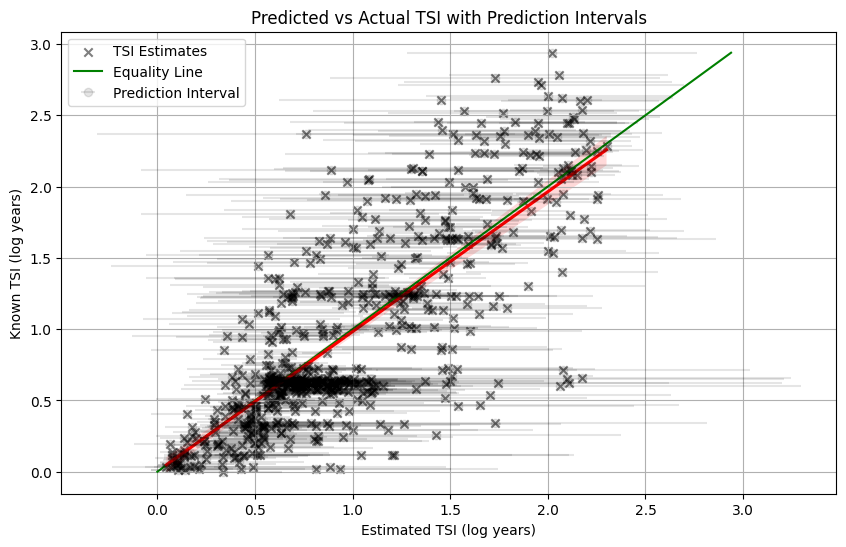

Overall R²: 0.61161162201123
Overall MAE: 0.31956164429440453


In [27]:
chosen_feature_set = 'base_plus_gp120_ambig_lrtt_coeff_1_lrtt_coeff_11' 

# Retrieve the stored evaluation results for the chosen feature set
chosen_results = evaluation_results[chosen_feature_set]

# Plot the results for the chosen feature set
plot_with_prediction_intervals(
    chosen_results['all_y_true'], 
    chosen_results['all_y_pred'], 
    chosen_results['all_prediction_intervals'],
    img_output='./outputs/predictions/log_tsi_best_feature_set.pdf'
)

overall_r2 = r2_score(chosen_results['all_y_true'], chosen_results['all_y_pred'])

# Calculate overall MAE
overall_mae = mean_absolute_error(chosen_results['all_y_true'], chosen_results['all_y_pred'])

print(f"Overall R²: {overall_r2}")
print(f"Overall MAE: {overall_mae}")

# Baseline: Botswana Predictions Plot 

In [185]:
#READ DATA
data_frames = read_datasets()
agg_data_df, _, _, _, rakai_phylo_data_df = data_frames.values()

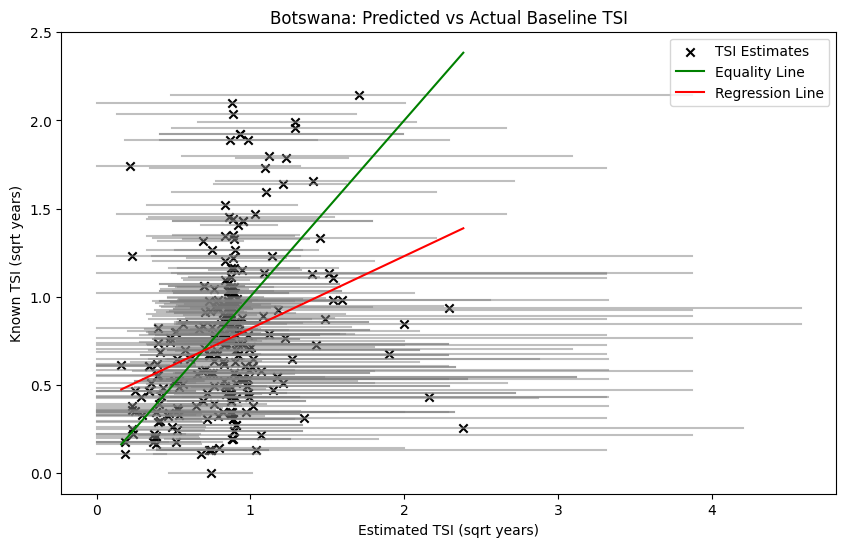

In [186]:
agg_data_df['sqrt_known_TSI'] = np.sqrt(agg_data_df['TSI_days'] / 365) #convert known tsi to sqrt years 
X = agg_data_df[['RF_pred_sqrt']].values  #predicted tsi
y = agg_data_df['sqrt_known_TSI'].values  #known tsi

#regression line
reg = LinearRegression().fit(X, y)
x_vals_regression = np.linspace(min(X), max(X), 100).reshape(-1, 1)
y_vals_regression = reg.predict(x_vals_regression)

#Plot
plt.figure(figsize=(10, 6))
plt.scatter(agg_data_df['RF_pred_sqrt'], agg_data_df['sqrt_known_TSI'], label= "TSI Estimates", color='black', marker='x')
for i in range(len(agg_data_df)):
    plt.plot([agg_data_df['RF_cc025'].iloc[i], agg_data_df['RF_cc975'].iloc[i]],
             [agg_data_df['sqrt_known_TSI'].iloc[i], agg_data_df['sqrt_known_TSI'].iloc[i]], color='gray', alpha=0.5)

x_vals = np.linspace(min(agg_data_df['RF_pred_sqrt']), max(agg_data_df['RF_pred_sqrt']), 100)
plt.plot(x_vals, x_vals, color='green', label="Equality Line")
plt.plot(x_vals_regression, y_vals_regression, color='red', label="Regression Line")
plt.xlabel("Estimated TSI (sqrt years)")
plt.ylabel("Known TSI (sqrt years)")
plt.title("Botswana: Predicted vs Actual Baseline TSI")
plt.legend()
plt.savefig('./outputs/predictions/sqrt_TSI_botswana.png')
plt.show()

# Baseline: Rakai Predictions Plot

In [187]:
import pyreadr

# Load the RDS file
rds_path = "./data/raw/Rakai_TSI.RDS"
rakai_data = pyreadr.read_r(rds_path)[None] 
rakai_phylo_data_dfphylo = pd.read_csv('./data/derived/imputed_phylo_data.csv') # to map known TSI values 


/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_8501/100627460.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  rakai_phylo_data_dfphylo = pd.read_csv('./data/derived/imputed_phylo_data.csv') # to map known TSI values


In [188]:
phylo_cleaned = rakai_phylo_data_df.drop_duplicates(subset=['host.id', 'TSI_days'])
rakai_data = pd.merge(rakai_data, 
                      phylo_cleaned[['host.id', 'TSI_days']], 
                      left_on=['RENAME_ID'], 
                      right_on=['host.id'], 
                      how='left')
rakai_data = rakai_data.drop(columns=['host.id'])


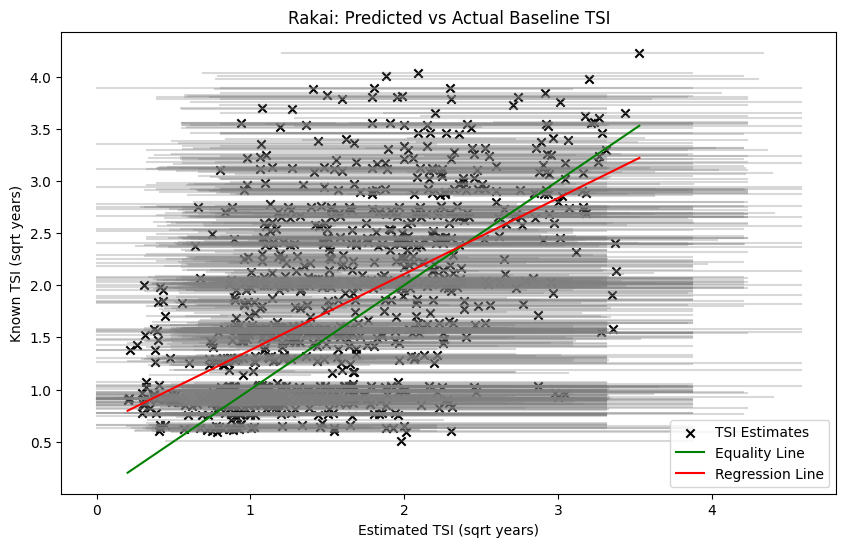

In [189]:
rakai_data['sqrt_known_TSI'] = np.sqrt(rakai_data['TSI_days'] / 365) #convert known to sqrt years
X = rakai_data[['RF_PRED_SQRT']].values  #predicted tsi
y = rakai_data['sqrt_known_TSI'].values  #known tsi

reg = LinearRegression().fit(X, y)
x_vals_regression = np.linspace(min(X), max(X), 100).reshape(-1, 1)
y_vals_regression = reg.predict(x_vals_regression)

plt.figure(figsize=(10, 6))
for i in range(len(rakai_data)):
    plt.plot([rakai_data['RF_CC025'].iloc[i], rakai_data['RF_CC975'].iloc[i]],
             [rakai_data['sqrt_known_TSI'].iloc[i], rakai_data['sqrt_known_TSI'].iloc[i]], color='gray', alpha=0.3)
    
plt.scatter(rakai_data['RF_PRED_SQRT'], rakai_data['sqrt_known_TSI'], 
            label="TSI Estimates", color='black', marker='x')

x_vals = np.linspace(min(rakai_data['RF_PRED_SQRT']), max(rakai_data['RF_PRED_SQRT']), 100)
plt.plot(x_vals, x_vals, color='green', label="Equality Line")
plt.plot(x_vals_regression, y_vals_regression, color='red', label="Regression Line")
plt.xlabel("Estimated TSI (sqrt years)")
plt.ylabel("Known TSI (sqrt years)")
plt.title("Rakai: Predicted vs Actual Baseline TSI")
plt.legend()
plt.savefig('./outputs/predictions/sqrt_TSI_rakai.png')
plt.show()

# Baseline: Rakai + Botswana

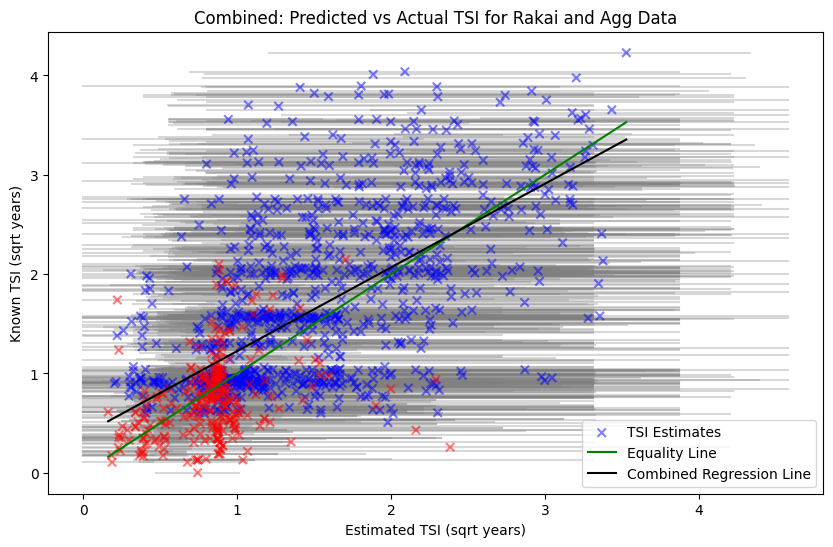

In [198]:
agg_data_df.rename(columns={
    'RF_pred_sqrt': 'RF_PRED_SQRT',
    'RF_cc025': 'RF_CC025',
    'RF_cc975': 'RF_CC975'
}, inplace=True)

rakai_data['Source'] = 'Rakai'
agg_data_df['Source'] = 'Agg'
combined_df = pd.concat([rakai_data, agg_data_df], ignore_index=True)

# Ensure that both have the same units for 'sqrt_known_TSI' and 'RF_PRED_SQRT'
combined_df['sqrt_known_TSI'] = np.sqrt(combined_df['TSI_days'] / 365)
X_combined = combined_df[['RF_PRED_SQRT']].values  # Predicted TSI (sqrt years)
y_combined = combined_df['sqrt_known_TSI'].values  # Known TSI (sqrt years)

reg_combined = LinearRegression().fit(X_combined, y_combined)
x_vals_combined = np.linspace(min(X_combined), max(X_combined), 100).reshape(-1, 1)
y_vals_combined = reg_combined.predict(x_vals_combined)

#Plot
plt.figure(figsize=(10, 6))
for i in range(len(combined_df)):
    plt.plot([combined_df['RF_CC025'].iloc[i], combined_df['RF_CC975'].iloc[i]],
             [combined_df['sqrt_known_TSI'].iloc[i], combined_df['sqrt_known_TSI'].iloc[i]], 
             color='gray', alpha=0.3, zorder=1)
plt.scatter(combined_df['RF_PRED_SQRT'], combined_df['sqrt_known_TSI'], 
            label="TSI Estimates", c=combined_df['Source'].apply(lambda x: 'blue' if x == 'Rakai' else 'red'), marker='x', alpha = 0.5, zorder=2)
x_vals = np.linspace(min(combined_df['RF_PRED_SQRT']), max(combined_df['RF_PRED_SQRT']), 100)
plt.plot(x_vals, x_vals, color='green', label="Equality Line")
plt.plot(x_vals_combined, y_vals_combined, color='black', label="Combined Regression Line")
plt.xlabel("Estimated TSI (sqrt years)")
plt.ylabel("Known TSI (sqrt years)")
plt.title("Combined: Predicted vs Actual TSI for Rakai and Agg Data")
plt.legend()
plt.show()

# Baseline - HIV-phyloTSI on new training set

In [28]:
features = features_tanya #hivphylotsi features

In [29]:
input_dir = './data/derived/unsmoothed/10folds/'
all_results_baseline = pd.DataFrame()
hivphylotsi_results = {}
print("Evaluating feature set")

# Perform the evaluation
metrics_df, all_y_true, all_y_pred, all_prediction_intervals = evaluate_model_with_errors(
    input_dir, None, features, n_folds=10)
all_results_baseline = pd.concat([all_results_baseline, metrics_df], ignore_index=True)

# Store the evaluation results
hivphylotsi_results = {
    'metrics_df': metrics_df,
    'all_y_true': all_y_true,
    'all_y_pred': all_y_pred,
    'all_prediction_intervals': all_prediction_intervals
}

Evaluating feature set
Fold 1: MSE = 0.20797980834984806, MAE = 0.34884022330432835, R² = 0.5558035930687326
Fold 2: MSE = 0.12250018448295642, MAE = 0.25370764798849754, R² = 0.6590027603631965
Fold 3: MSE = 0.30939510530072833, MAE = 0.43967367042839495, R² = 0.48700587932833717
Fold 4: MSE = 0.2697430789594906, MAE = 0.3874210530855466, R² = 0.5429525393438418
Fold 5: MSE = 0.2224736857331792, MAE = 0.33385995883044695, R² = 0.5661400024653012
Fold 6: MSE = 0.18566360672063092, MAE = 0.31567969675157365, R² = 0.5956203591712936
Fold 7: MSE = 0.19821764888790952, MAE = 0.3232992526603667, R² = 0.5484500261398777
Fold 8: MSE = 0.21889484909629453, MAE = 0.3627031879645663, R² = 0.6105986693967863
Fold 9: MSE = 0.1934614104059293, MAE = 0.33981986049402996, R² = 0.5250325044632347
Fold 10: MSE = 0.15064388487869607, MAE = 0.30869137635115734, R² = 0.5306362186546489


<Figure size 1000x600 with 0 Axes>

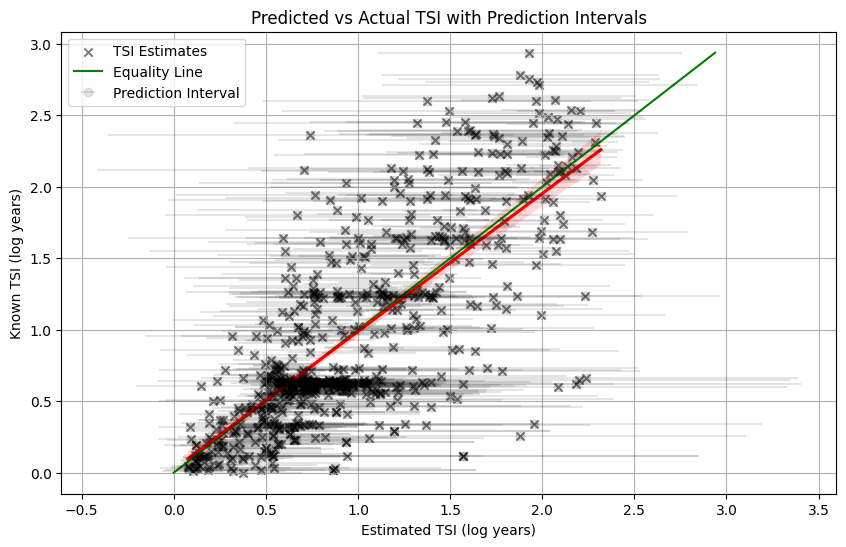

In [252]:
plt.figure(figsize=(10, 6))

plot_with_prediction_intervals(
    hivphylotsi_results['all_y_true'], 
    hivphylotsi_results['all_y_pred'], 
    hivphylotsi_results['all_prediction_intervals'],
    img_output = './outputs/predictions/log_tsi_hivphilotsi.pdf'
)

In [253]:
overall_r2 = r2_score(hivphylotsi_results['all_y_true'], hivphylotsi_results['all_y_pred'])

# Calculate overall MAE
overall_mae = mean_absolute_error(hivphylotsi_results['all_y_true'], hivphylotsi_results['all_y_pred'])

print(f"Overall R²: {overall_r2}")
print(f"Overall MAE: {overall_mae}")

Overall R²: 0.5645852319528938
Overall MAE: 0.3416529689673829


# Final Comparison

In [41]:
baseline_r2_values = all_results_baseline['R²'].values
baseline_mae_values = all_results_baseline['MAE'].values

In [42]:
# Perform paired t-test for R²
t_stat_r2, p_value_r2 = ttest_rel(best_r2_values, baseline_r2_values)

# Perform paired t-test for MAE
t_stat_mae, p_value_mae = ttest_rel(best_mae_values, baseline_mae_values)

# Output the R² comparison results
print("R² Comparison:")
print(f"T-statistic: {t_stat_r2}")
print(f"P-value: {p_value_r2}")

alpha = 0.05 #no correction needed for single comparison
if p_value_r2 < alpha:
    print("The difference in R² between the best feature set and baseline is statistically significant.")
else:
    print("The difference in R² between the best feature set and baseline is not statistically significant.")

# Output the MAE comparison results
print("\nMAE Comparison:")
print(f"T-statistic: {t_stat_mae}")
print(f"P-value: {p_value_mae}")

if p_value_mae < alpha:
    print("The difference in MAE between the best feature set and baseline is statistically significant.")
else:
    print("The difference in MAE between the best feature set and baseline is not statistically significant.")

R² Comparison:
T-statistic: 4.510463521967483
P-value: 0.001466733100140399
The difference in R² between the best feature set and baseline is statistically significant.

MAE Comparison:
T-statistic: -5.080823592694852
P-value: 0.0006620962360451898
The difference in MAE between the best feature set and baseline is statistically significant.
